# Project M6: Classification of Swiss Government Press Releases with BERT
Press releases of the Swiss Government are per definition public available data and are therefore perfectly suited to conduct a research project in NLP.

The press releases can be accessed via an RSS feed and each press release is assigned to one or more predefined topics (i.e. multi-label). There are in total 44 different topics and a total of approximately 17'000 unique press releases in the German language published between 1.1.2015 and 28.1.2023 (approx. 7 press releases per day). Link to access press releases:   

RSS feed: https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen/rss-feeds/nach-themen/medienmitteilungen-und-reden.html?dyn_startDate=01.07.2021   
Web: https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.html?dyn_startDate=01.07.2021&dyn_organization=1

Goal of this project is to build different classifiers based on a pretrained BERT model using the German press releases:   
- Simple binary classification problem (two classes only with press releases assigned to one of the classes and not both)
- Multi-label classification with same two classes
- Multi-label classification with top topics (topics with > 1200 press releases)
- Multi-label classification with all topics

The performance of the classifiers gives also an indication about how helpful the different topics are from a user perspective and if they are really separable based on BERT embeddings.

In [1]:
!pip install datasets transformers feedparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB

In [2]:
import pandas as pd
from tqdm import tqdm
import feedparser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
import torch
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

root_dir ='drive/MyDrive/medienmitteilungen'

Mounted at /content/drive


### 1. Retrieve press releases

Topic values, see table dropdown in source: view-source:https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen/rss-feeds/nach-themen/medienmitteilungen-und-reden.html?dyn_startDate=01.01.2015&dyn_endDate=20.01.2023&dyn_topic=42

In [ ]:
topics = {
    1: 'Amtliche Veröffentlichungen',
    2: 'Arbeit',
    3: 'Armee',
    30: 'Ausserordentliche Lagen',
    5: 'Behörden',
    7: 'Bibliotheken und Archive',
    8: 'Bildung und Forschung',
    32: 'Bundespersonal',
    33: 'Bundespräsident/-in',
    10: 'Bundesrat',
    31: 'Bund und Kantone',
    11: 'Energie',
    34: 'Europa',
    35: 'Finanzplatz',
    101: 'Frankenstärke',
    14: 'Gerichte',
    15: 'Gesundheit',
    36: 'Informatik und E-Government',
    37: 'Konsum',
    17: 'Kriminalität',
    18: 'Kultur',
    38: 'Landwirtschaft',
    19: 'Medien',
    20: 'Migration',
    24: 'Öffentliche Beschaffungen',
    13: 'Öffentliche Finanzen',
    22: 'Parlament',
    23: 'Politische Rechte',
    25: 'Raumplanung',
    26: 'Recht',
    27: 'Reisen und Tourismus',
    39: 'Schweiz und Ausland',
    40: 'Sicherheit',
    41: 'Soziales',
    42: 'Sport',
    43: 'Statistik',
    44: 'Steuern',
    45: 'Technologie',
    28: 'Telekommunikation',
    29: 'Umwelt und Natur',
    46: 'Verkehr',
    47: 'Wirtschaft',
    48: 'Zoll',
    102: 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen',
}

topics

{1: 'Amtliche Veröffentlichungen',
 2: 'Arbeit',
 3: 'Armee',
 30: 'Ausserordentliche Lagen',
 5: 'Behörden',
 7: 'Bibliotheken und Archive',
 8: 'Bildung und Forschung',
 32: 'Bundespersonal',
 33: 'Bundespräsident/-in',
 10: 'Bundesrat',
 31: 'Bund und Kantone',
 11: 'Energie',
 34: 'Europa',
 35: 'Finanzplatz',
 101: 'Frankenstärke',
 14: 'Gerichte',
 15: 'Gesundheit',
 36: 'Informatik und E-Government',
 37: 'Konsum',
 17: 'Kriminalität',
 18: 'Kultur',
 38: 'Landwirtschaft',
 19: 'Medien',
 20: 'Migration',
 24: 'Öffentliche Beschaffungen',
 13: 'Öffentliche Finanzen',
 22: 'Parlament',
 23: 'Politische Rechte',
 25: 'Raumplanung',
 26: 'Recht',
 27: 'Reisen und Tourismus',
 39: 'Schweiz und Ausland',
 40: 'Sicherheit',
 41: 'Soziales',
 42: 'Sport',
 43: 'Statistik',
 44: 'Steuern',
 45: 'Technologie',
 28: 'Telekommunikation',
 29: 'Umwelt und Natur',
 46: 'Verkehr',
 47: 'Wirtschaft',
 48: 'Zoll',
 102: 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen'}

In [ ]:
print('Number of categories:', len(topics.keys()))

Number of categories: 44


In [ ]:
# Get messages per topic and label them accordingly
# The raw message doesn't contain topic classification, we only get classification by access them through topic filters
all_entries_raw = {}

start_date = '2015-01-01'
end_date = '2023-01-28'

# Loop through keys and gather raw data
for topic_key in list(topics.keys()):

    print('Get data for key:', topic_key, topics[topic_key])
    url = f'https://www.newsd.admin.ch/newsd/feeds/rss?lang=de&org-nr=1&topic={topic_key}&keyword=&offer-nr=&catalogueElement=&kind=M%2CR&start_date={start_date}&end_date={end_date}'
    
    response = feedparser.parse(url)
    print('Number of Entries: ', len(response.entries))
    
    all_entries_raw.update({topic_key: response.entries})

Get data for key: 1 Amtliche Veröffentlichungen
Number of Entries:  30
Get data for key: 2 Arbeit
Number of Entries:  861
Get data for key: 3 Armee
Number of Entries:  1240
Get data for key: 30 Ausserordentliche Lagen
Number of Entries:  430
Get data for key: 5 Behörden
Number of Entries:  1072
Get data for key: 7 Bibliotheken und Archive
Number of Entries:  80
Get data for key: 8 Bildung und Forschung
Number of Entries:  1403
Get data for key: 32 Bundespersonal
Number of Entries:  206
Get data for key: 33 Bundespräsident/-in
Number of Entries:  572
Get data for key: 10 Bundesrat
Number of Entries:  6055
Get data for key: 31 Bund und Kantone
Number of Entries:  660
Get data for key: 11 Energie
Number of Entries:  1077
Get data for key: 34 Europa
Number of Entries:  725
Get data for key: 35 Finanzplatz
Number of Entries:  652
Get data for key: 101 Frankenstärke
Number of Entries:  27
Get data for key: 14 Gerichte
Number of Entries:  86
Get data for key: 15 Gesundheit
Number of Entries: 

In [ ]:
# Look at a raw message
all_entries_raw[1][0]

{'title': 'Keine Zustimmung zu einer Weitergabe von Schweizer Kriegsmaterial an die Ukraine',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://www.newsd.admin.ch/newsd/feeds/rss?lang=de&org-nr=1&topic=1&keyword=&offer-nr=&catalogueElement=&kind=M%2CR&start_date=2015-01-01&end_date=2023-01-28',
  'value': 'Keine Zustimmung zu einer Weitergabe von Schweizer Kriegsmaterial an die Ukraine'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.msg-id-91146.html'}],
 'link': 'https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.msg-id-91146.html',
 'summary': 'Bundesrat Guy Parmelin, Vorsteher des Eidgenössischen Departements für Wirtschaft, Bildung und Forschung (WBF), hat am 3. November 2022 im Auftrag des Bundesrats ein Schreiben der deutschen Bundesministerin der Verteidigung, Christine Lambrecht, beantwortet.',
 'summary_detail': {'type': 'text/html',
  'languag

In [ ]:
entries_flat = []

for topic in all_entries_raw:
    
    for entry in all_entries_raw[topic]:
        
        entries_flat.append({'title': entry.title, 
                             'summary': entry.summary,
                             'text': entry.title + ' ' + entry.summary, # Text = Title + Summary
                             'text_len': len(entry.title + ' ' + entry.summary), # Number of characters
                             'author': entry.author, 
                             'published': entry.published,
                             'link': entry.link,
                             'topic': topic,
                             'topic_name': topics[topic]})
        
entries_flat_df = pd.DataFrame(entries_flat)
entries_flat_df.head()

,title,summary,text,text_len,author,published,link,topic,topic_name
0,Keine Zustimmung zu einer Weitergabe von Schwe...,"Bundesrat Guy Parmelin, Vorsteher des Eidgenös...",Keine Zustimmung zu einer Weitergabe von Schwe...,339,"Eidgenössisches Departement für Wirtschaft, Bi...",2022-11-03,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen
1,Bundeskanzlei veröffentlicht Bundesrecht neu a...,Mit Inkrafttreten der geänderten Publikationsv...,Bundeskanzlei veröffentlicht Bundesrecht neu a...,309,Bundeskanzlei,2022-08-11,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen
2,Terrorismusbekämpfung: Verfügungsentwurf für O...,Von Terror-Organisationen wie «Al-Qaïda» oder ...,Terrorismusbekämpfung: Verfügungsentwurf für O...,745,Nachrichtendienst des Bundes,2022-07-26,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen
3,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen
4,Völkerrechtsverletzungen in der Ukraine: Weite...,Im Zusammenhang mit den schweren Völkerrechtsv...,Völkerrechtsverletzungen in der Ukraine: Weite...,453,"Eidgenössisches Departement für Wirtschaft, Bi...",2022-03-16,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen


In [ ]:
# Save entries_flat_df
entries_flat_df.to_pickle(f'{root_dir}/entries_flat_df.pkl')

### 2. EDA

#### Basic statistics and examples

In [37]:
# Load data
entries_flat_df = pd.read_pickle(f'{root_dir}/entries_flat_df.pkl')

In [ ]:
# Stats
entries_flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44083 entries, 0 to 44082
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44083 non-null  object
 1   summary     44083 non-null  object
 2   text        44083 non-null  object
 3   text_len    44083 non-null  int64 
 4   author      44083 non-null  object
 5   published   44083 non-null  object
 6   link        44083 non-null  object
 7   topic       44083 non-null  int64 
 8   topic_name  44083 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.0+ MB


In [ ]:
entries_flat_df.sort_values(by='published', ascending=False).head()

,title,summary,text,text_len,author,published,link,topic,topic_name
5322,Internationaler Tag des Gedenkens an die Opfer...,Botschaft von Bundespräsident Alain Berset zum...,Internationaler Tag des Gedenkens an die Opfer...,169,Eidgenössisches Departement des Innern,2023-01-27,https://www.admin.ch/gov/de/start/dokumentatio...,33,Bundespräsident/-in
36032,Finanzspritze für Empa-Forschungsvorhaben: Pfl...,Empa-Forschende wollen ein neuartiges Dämmmate...,Finanzspritze für Empa-Forschungsvorhaben: Pfl...,602,Eidg. Materialprüfungs- und Forschungsanstalt,2023-01-27,https://www.admin.ch/gov/de/start/dokumentatio...,29,Umwelt und Natur
22200,Ausgabe der neuen Sondermünze «Rosenlauigletsc...,Am 31. Januar 2023 lanciert die Eidgenössische...,Ausgabe der neuen Sondermünze «Rosenlauigletsc...,990,Eidgenössische Münzstätte Swissmint,2023-01-27,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen
12609,Finanzspritze für Empa-Forschungsvorhaben: Pfl...,Empa-Forschende wollen ein neuartiges Dämmmate...,Finanzspritze für Empa-Forschungsvorhaben: Pfl...,602,Eidg. Materialprüfungs- und Forschungsanstalt,2023-01-27,https://www.admin.ch/gov/de/start/dokumentatio...,11,Energie
23541,Internationaler Tag des Gedenkens an die Opfer...,Botschaft von Bundespräsident Alain Berset zum...,Internationaler Tag des Gedenkens an die Opfer...,169,Eidgenössisches Departement des Innern,2023-01-27,https://www.admin.ch/gov/de/start/dokumentatio...,26,Recht


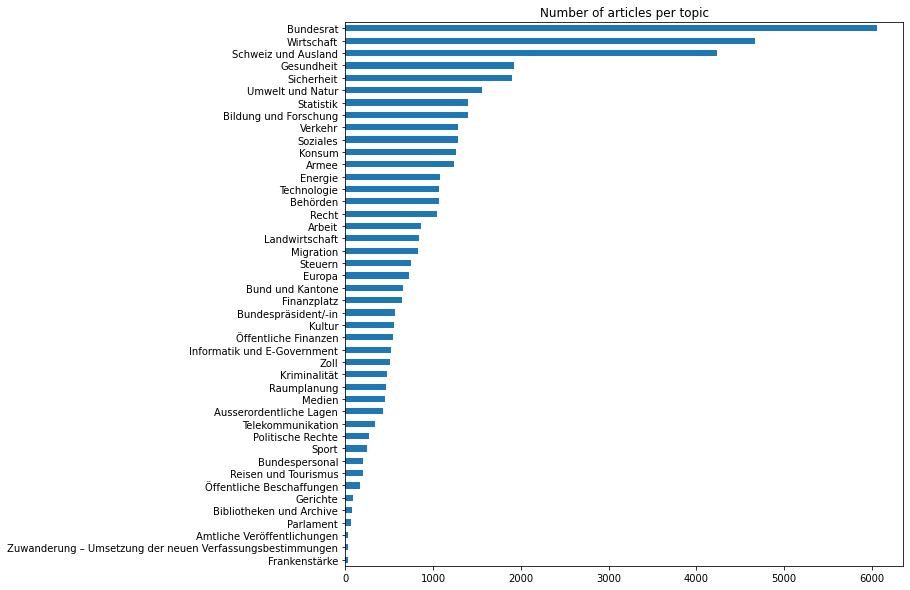

In [ ]:
plt.figure(figsize=(10,10))
entries_flat_df['topic_name'].value_counts(ascending=True).plot.barh()
plt.title('Number of articles per topic')
plt.show()

In [ ]:
entries_flat_df['topic_name'].value_counts()

Bundesrat                                                    6055
Wirtschaft                                                   4672
Schweiz und Ausland                                          4236
Gesundheit                                                   1918
Sicherheit                                                   1900
Umwelt und Natur                                             1560
Statistik                                                    1404
Bildung und Forschung                                        1403
Verkehr                                                      1285
Soziales                                                     1282
Konsum                                                       1259
Armee                                                        1240
Energie                                                      1077
Technologie                                                  1074
Behörden                                                     1072
Recht     

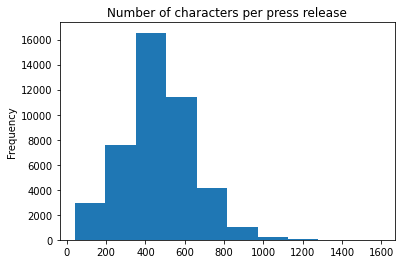

In [ ]:
entries_flat_df['text_len'].plot.hist()
plt.title('Number of characters per press release')
plt.show()

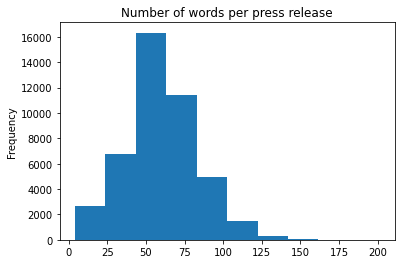

In [ ]:
entries_flat_df['num_words'] = entries_flat_df['text'].apply(lambda x: len(str.split(x)))
entries_flat_df['num_words'].plot.hist()
plt.title('Number of words per press release')
plt.show()

In [ ]:
entries_flat_df[['text_len', 'num_words']].describe()

,text_len,num_words
count,44083.000000,44083.000000
mean,465.911553,60.408366
std,177.721903,23.304146
min,41.000000,4.000000
25%,355.000000,46.000000
50%,459.000000,59.000000
75%,571.000000,74.000000
max,1590.000000,201.000000


In [ ]:
# Longest text (most characters)
entries_flat_df.sort_values(by='text_len', ascending=False).iloc[0].text

'Empfehlungen der EKM zur obligatorischen Bildung von geflüchteten Kindern und Jugendlichen Rund 40 Prozent der Geflüchteten aus der Ukraine sind Kinder und Jugendliche. Damit entstehen für die Bildungsinstitutionen, namentlich für die Erziehungsdirektionen der Kantone, für die Schulbehörden in den Gemeinden und für die Lehrpersonen grosse Herausforderungen. Die Eidgenössische Migrationskommission EKM betrachtet die Bildung und die damit zusammenhängende gesundheitliche Versorgung der geflüchteten Kinder und Jugendlichen aus der Ukraine als eine besonders sensible Aufgabe. Sie soll darum gemeinsam von Bund, Kantonen und Pädagogischen Hochschulen getragen werden und sich in allen Umsetzungsschritten am Erhalt des Kindeswohls orientieren.\n\nDie EKM sieht den Bund – in seinem Bemühen um eine kohärente Migrationspolitik – in der Verantwortung zur finanziellen Beteiligung. Die Sozial- und Gesundheitsdirektionen sieht sie in der Pflicht gute Rahmenbedingungen für die Bildung zu schaffen und

In [ ]:
# Shortest text (fewest characters)
entries_flat_df.sort_values(by='text_len').iloc[0].text

'Von-Wattenwyl-Gespräche vom 7. Mai 2021 -'

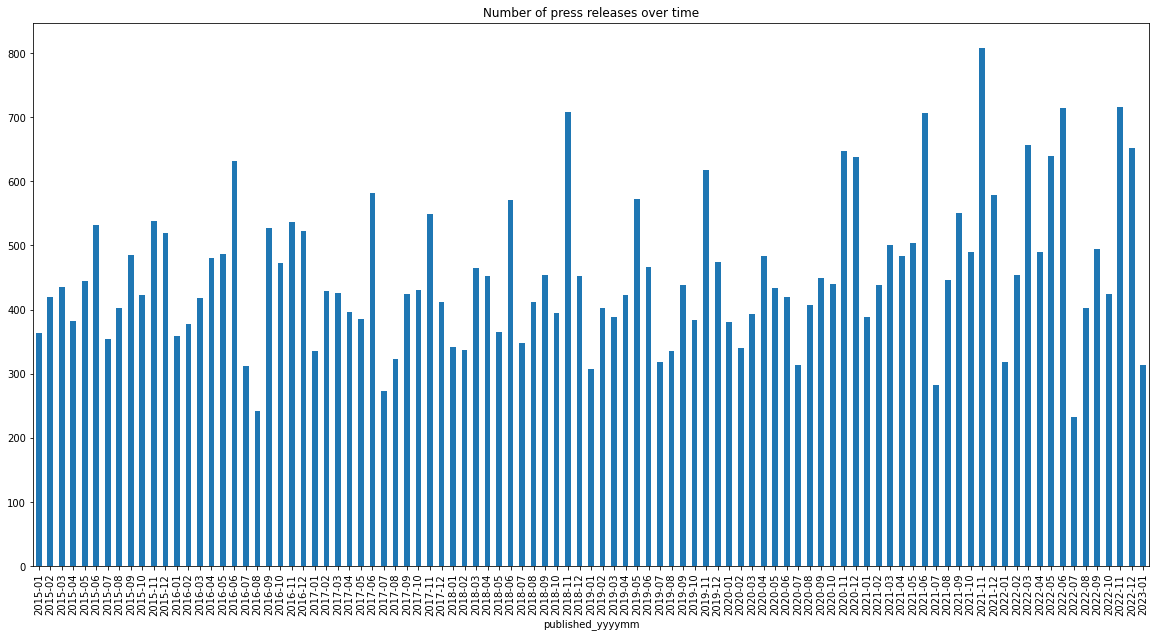

In [ ]:
# Number of press releases over time is stable
entries_flat_df['published_yyyymm'] = entries_flat_df['published'].apply(lambda x: x[:7])
entries_agg_yyyymm = entries_flat_df.groupby('published_yyyymm').count().sort_values(by='published_yyyymm')['title']
entries_agg_yyyymm.plot.bar(figsize=(20,10))
plt.title('Number of press releases over time')
plt.show()

In [ ]:
# Latest entries per topic
# Frankenstärke and Zuwanderung didn't have any recent press releases, look like one-off-topics
entries_flat_df.groupby('topic_name')['published'].max().sort_values()

topic_name
Frankenstärke                                                2021-09-17
Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen    2022-05-25
Amtliche Veröffentlichungen                                  2022-11-03
Parlament                                                    2022-12-09
Telekommunikation                                            2022-12-16
Gerichte                                                     2022-12-20
Raumplanung                                                  2022-12-22
Medien                                                       2022-12-30
Kriminalität                                                 2022-12-30
Informatik und E-Government                                  2023-01-12
Öffentliche Beschaffungen                                    2023-01-16
Bundespersonal                                               2023-01-17
Finanzplatz                                                  2023-01-18
Politische Rechte                                    

In [ ]:
# E.g. Frankenstärke, most press releases published in 2015/16, no recent press releases
entries_flat_df[entries_flat_df['topic_name']=='Frankenstärke'][['title', 'published']]

,title,published
15063,Fair-Preis-Initiative: Inkraftsetzung des indi...,2021-09-17
15064,Produzenten- und Importpreisindex sinkt im Jul...,2019-08-15
15065,Die Schweiz und die internationale Handelskrise,2019-01-16
15066,Bundesrat für befristete Verlängerung des MWST...,2017-04-12
15067,Handlungsoptionen bei tiefen Zinsen,2016-12-21
15068,Bundesrat verabschiedet Bericht zur Geldpolitik,2016-12-21
15069,Der Bundespräsident empfängt die Tourismus-Bra...,2016-09-26
15070,KTI finanziert ab 1. Juli Sondermassnahmen zur...,2016-06-30
15071,Verträge in der Milchbranche sollen verbessert...,2016-06-14
15072,Bundesrat genehmigt 61 Millionen Franken für z...,2016-02-17


#### Duplicate checks and multi-label definition

In [ ]:
# Check duplicates of summary text
count_per_topic_summary = entries_flat_df.groupby('summary').count()['topic'].sort_values(ascending=False).reset_index()
count_per_topic_summary.head()

,summary,topic
0,Bundesamt für Lebensmittelsicherheit und Veter...,414
1,Bundesamt für Lebensmittelsicherheit und Vete...,185
2,-,183
3,Informationen aus dem Staatssekretariat für Bi...,55
4,Übergabe der Beglaubigungsschreiben der neu in...,41


In [ ]:
count_per_topic_summary.iloc[:5].summary.values

array(['Bundesamt für Lebensmittelsicherheit und Veterinärwesen (BLV)',
       'Bundesamt  für Lebensmittelsicherheit und Veterinärwesen (BLV)',
       '-',
       'Informationen aus dem Staatssekretariat für Bildung, Forschung und Innovation SBFI',
       'Übergabe der Beglaubigungsschreiben der neu in der Schweiz akkreditierten Botschafterinnen und Botschafter'],
      dtype=object)

In [ ]:
# Examples of duplicates based on summary
# Emissionen von Anleihen (title contains date, summary the same)
entries_flat_df[entries_flat_df['summary']=='Optionaler Auktionstermin wird wahrgenommen.'].head()

,title,summary,text,text_len,author,published,link,topic,topic_name,num_words
22212,Emission einer eidgenössischen Anleihe am 14. ...,Optionaler Auktionstermin wird wahrgenommen.,Emission einer eidgenössischen Anleihe am 14. ...,104,Eidg. Finanzverwaltung,2022-11-30,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen,12
22228,Emission einer eidgenössischen Anleihe am 12. ...,Optionaler Auktionstermin wird wahrgenommen.,Emission einer eidgenössischen Anleihe am 12. ...,103,Eidg. Finanzverwaltung,2022-09-28,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen,12
22294,Emission einer eidgenössischen Anleihe am 8. D...,Optionaler Auktionstermin wird wahrgenommen.,Emission einer eidgenössischen Anleihe am 8. D...,103,Eidg. Finanzverwaltung,2021-11-24,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen,12
22308,Emission einer eidgenössischen Anleihe am 13. ...,Optionaler Auktionstermin wird wahrgenommen.,Emission einer eidgenössischen Anleihe am 13. ...,103,Eidg. Finanzverwaltung,2021-09-29,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen,12
22383,Emission einer eidgenössischen Anleihe am 9. D...,Optionaler Auktionstermin wird wahrgenommen.,Emission einer eidgenössischen Anleihe am 9. D...,103,Eidg. Finanzverwaltung,2020-11-19,https://www.admin.ch/gov/de/start/dokumentatio...,13,Öffentliche Finanzen,12


In [ ]:
# Examples of duplicates based on summary
# Rückrufe (title contains details, summary same)
entries_flat_df[entries_flat_df['summary']=='Bundesamt für Lebensmittelsicherheit und Veterinärwesen (BLV)'].head()

,title,summary,text,text_len,author,published,link,topic,topic_name,num_words
15844,BLV – SM Seafood GmbH ruft Sepia Pharaonis weg...,Bundesamt für Lebensmittelsicherheit und Veter...,BLV – SM Seafood GmbH ruft Sepia Pharaonis weg...,140,Eidgenössisches Büro für Konsumentenfragen,2020-11-27,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit,19
15850,BLV – Globus ruft die Produkte Vilmas Bio Knäc...,Bundesamt für Lebensmittelsicherheit und Veter...,BLV – Globus ruft die Produkte Vilmas Bio Knäc...,180,Eidgenössisches Büro für Konsumentenfragen,2020-11-24,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit,24
15852,BLV – Morga AG ruft verschiedene Produkte mit ...,Bundesamt für Lebensmittelsicherheit und Veter...,BLV – Morga AG ruft verschiedene Produkte mit ...,146,Eidgenössisches Büro für Konsumentenfragen,2020-11-23,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit,18
15863,BLV – Zwicky ruft verschiedene Sesamprodukte w...,Bundesamt für Lebensmittelsicherheit und Veter...,BLV – Zwicky ruft verschiedene Sesamprodukte w...,139,Eidgenössisches Büro für Konsumentenfragen,2020-11-16,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit,15
15864,BLV – Biofarm ruft die Produkte «Sesam geschäl...,Bundesamt für Lebensmittelsicherheit und Veter...,BLV – Biofarm ruft die Produkte «Sesam geschäl...,209,Eidgenössisches Büro für Konsumentenfragen,2020-11-16,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit,31


In [ ]:
# Examples of duplicates based on summary
# Rede von Bundesrätin Simonetta Sommaruga, different speeches, but also the same speech in different topics
entries_flat_df[entries_flat_df['summary']=='Rede von Bundesrätin Simonetta Sommaruga'].head()

,title,summary,text,text_len,author,published,link,topic,topic_name,num_words
5567,Spatenstich Einhausung Schwamendingen,Rede von Bundesrätin Simonetta Sommaruga,Spatenstich Einhausung Schwamendingen Rede von...,78,Generalsekretariat UVEK,2019-04-01,https://www.admin.ch/gov/de/start/dokumentatio...,33,Bundespräsident/-in,8
6012,Eröffnung Limmattalbahn,Rede von Bundesrätin Simonetta Sommaruga,Eröffnung Limmattalbahn Rede von Bundesrätin S...,64,Generalsekretariat UVEK,2022-12-09,https://www.admin.ch/gov/de/start/dokumentatio...,10,Bundesrat,7
6169,NET-Tagung BAFU,Rede von Bundesrätin Simonetta Sommaruga,NET-Tagung BAFU Rede von Bundesrätin Simonetta...,56,Generalsekretariat UVEK,2022-10-14,https://www.admin.ch/gov/de/start/dokumentatio...,10,Bundesrat,7
6201,Verkehrsforum 2022 der LITRA,Rede von Bundesrätin Simonetta Sommaruga,Verkehrsforum 2022 der LITRA Rede von Bundesrä...,69,Generalsekretariat UVEK,2022-09-29,https://www.admin.ch/gov/de/start/dokumentatio...,10,Bundesrat,9
6276,Städtetag 2022,Rede von Bundesrätin Simonetta Sommaruga,Städtetag 2022 Rede von Bundesrätin Simonetta ...,55,Generalsekretariat UVEK,2022-08-25,https://www.admin.ch/gov/de/start/dokumentatio...,10,Bundesrat,7


In [ ]:
# Check if duplicates based on title text
count_per_topic_title = entries_flat_df.groupby('title').count()['topic'].sort_values(ascending=False).reset_index()
count_per_topic_title.head()

,title,topic
0,Informieren Sie sich über die Gleichstellung v...,205
1,Publikationshinweis,139
2,Beförderungen im Offizierskorps,126
3,Neue Eidgenössische Anleihen,112
4,Emissionsergebnis der Bundesanleihen,112


In [ ]:
count_per_topic_title.iloc[:5].title.values

array(['Informieren Sie sich über die Gleichstellung von Menschen mit Behinderungen',
       'Publikationshinweis', 'Beförderungen im Offizierskorps',
       'Neue Eidgenössische Anleihen',
       'Emissionsergebnis der Bundesanleihen'], dtype=object)

In [ ]:
# Examples of duplicates based on title
# Newsletter über Gleichstellung, different newsletters with different published date with same title, but also same newsletter in different topics
entries_flat_df[entries_flat_df['title']=='Informieren Sie sich über die Gleichstellung von Menschen mit Behinderungen'].head()

,title,summary,text,text_len,author,published,link,topic,topic_name,num_words
35,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,13
83,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 03/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-09-06,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,13
107,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 02/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-06-02,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,13
142,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 01/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-03-10,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,13
160,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 06/2021,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2021-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,13


In [ ]:
# The same newsletter with same published date is present in multiple different topics, real duplicate
entries_flat_df[entries_flat_df['summary']=='Newsletter EBGB 04/2022']

,title,summary,text,text_len,author,published,link,topic,topic_name
35,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit
2571,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,5,Behörden
3724,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,8,Bildung und Forschung
11952,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,31,Bund und Kantone
15196,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,15,Gesundheit
17095,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,36,Informatik und E-Government
19357,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,18,Kultur
20755,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,19,Medien
22813,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,23,Politische Rechte
23549,Informieren Sie sich über die Gleichstellung v...,Newsletter EBGB 04/2022,Informieren Sie sich über die Gleichstellung v...,99,Generalsekretariat EDI,2022-12-20,https://www.admin.ch/gov/de/start/dokumentatio...,26,Recht


In [ ]:
# Examples of duplicates based on title
# Kenntnissnahme des Berichts "Schweiz 2035" vom Bundesrat, same message with same published date in different topics
# Real duplicate, title and summary are duplicated
entries_flat_df[entries_flat_df['title']=='Bundesrat nimmt den Bericht «Schweiz 2035» zur Kenntnis']

,title,summary,text,text_len,author,published,link,topic,topic_name
3,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,1,Amtliche Veröffentlichungen
113,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit
1012,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,3,Armee
2209,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,30,Ausserordentliche Lagen
3639,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,7,Bibliotheken und Archive
3866,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,8,Bildung und Forschung
11983,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,31,Bund und Kantone
12755,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,11,Energie
13764,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,34,Europa
14468,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,Der Bundesrat hat am 25. Mai 2022 vom Bericht ...,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,434,Bundeskanzlei,2022-05-25,https://www.admin.ch/gov/de/start/dokumentatio...,35,Finanzplatz


In [ ]:
# Check if entry is present in different topics based on complete text (i.e. title + summary) and published date
count_per_topic_text = entries_flat_df.groupby(['text', 'published']).count()['topic'].sort_values(ascending=False).reset_index()
count_per_topic_text

,text,published,topic
0,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,2022-05-25,32
1,Schweiz übernimmt EU-Sanktionen gegen Russland...,2022-02-28,18
2,WEKO: Neue Vizedirektorin und neuer Kommunikat...,2018-09-18,17
3,Ukraine: Weitere Güter- und Finanzsanktionen g...,2022-03-04,16
4,"Coronavirus: Bundesrat beschliesst weiteren, g...",2021-06-23,16
...,...,...,...
17751,Das Bundesamt für Landwirtschaft BLW informier...,2022-03-28,1
17752,Das Bundesamt für Landwirtschaft BLW informier...,2022-05-30,1
17753,Das Bundesamt für Landwirtschaft BLW informier...,2022-08-30,1
17754,Das Bundesamt für Landwirtschaft BLW informier...,2022-09-29,1


In [ ]:
# 12314 messages are present in more than 1 topic
count_per_topic_text[count_per_topic_text['topic']>1]

,text,published,topic
0,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,2022-05-25,32
1,Schweiz übernimmt EU-Sanktionen gegen Russland...,2022-02-28,18
2,WEKO: Neue Vizedirektorin und neuer Kommunikat...,2018-09-18,17
3,Ukraine: Weitere Güter- und Finanzsanktionen g...,2022-03-04,16
4,"Coronavirus: Bundesrat beschliesst weiteren, g...",2021-06-23,16
...,...,...,...
12309,Ein Teilchenbeschleuniger für den Bürotisch: E...,2022-12-15,2
12310,Bundesrat passt Verordnungen im Bereich der Ar...,2020-11-25,2
12311,Energie: Bundesrat legt Bericht zur Wärme-Kraf...,2022-12-02,2
12312,9'738 Gesuche für neue .swiss-Domainnamen Die ...,2015-11-19,2


In [ ]:
# Examples of text duplicates present in different topics
entries_flat_df[entries_flat_df['text']=='WEKO: Neue Vizedirektorin und neuer Kommunikationsverantwortlicher Die Wettbewerbskommission (WEKO) hat mit Entscheid vom 17. September 2018 Andrea Graber Cardinaux zur Vizedirektorin ernannt. Sie wird ihr Amt am 1. Oktober 2018 antreten. Zudem wird Frank Stüssi, Vizedirektor, ab 1. Oktober 2018 die Rolle des Kommunikationsverantwortlichen wahrnehmen.'].head()

,title,summary,text,text_len,author,published,link,topic,topic_name,num_words
555,WEKO: Neue Vizedirektorin und neuer Kommunikat...,Die Wettbewerbskommission (WEKO) hat mit Entsc...,WEKO: Neue Vizedirektorin und neuer Kommunikat...,353,Wettbewerbskommission,2018-09-18,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit,45
3228,WEKO: Neue Vizedirektorin und neuer Kommunikat...,Die Wettbewerbskommission (WEKO) hat mit Entsc...,WEKO: Neue Vizedirektorin und neuer Kommunikat...,353,Wettbewerbskommission,2018-09-18,https://www.admin.ch/gov/de/start/dokumentatio...,5,Behörden,45
3673,WEKO: Neue Vizedirektorin und neuer Kommunikat...,Die Wettbewerbskommission (WEKO) hat mit Entsc...,WEKO: Neue Vizedirektorin und neuer Kommunikat...,353,Wettbewerbskommission,2018-09-18,https://www.admin.ch/gov/de/start/dokumentatio...,7,Bibliotheken und Archive,45
5210,WEKO: Neue Vizedirektorin und neuer Kommunikat...,Die Wettbewerbskommission (WEKO) hat mit Entsc...,WEKO: Neue Vizedirektorin und neuer Kommunikat...,353,Wettbewerbskommission,2018-09-18,https://www.admin.ch/gov/de/start/dokumentatio...,32,Bundespersonal,45
14726,WEKO: Neue Vizedirektorin und neuer Kommunikat...,Die Wettbewerbskommission (WEKO) hat mit Entsc...,WEKO: Neue Vizedirektorin und neuer Kommunikat...,353,Wettbewerbskommission,2018-09-18,https://www.admin.ch/gov/de/start/dokumentatio...,35,Finanzplatz,45


In [ ]:
# Only 5442 message are present in exactly one category
count_per_topic_text[count_per_topic_text['topic']==1]

,text,published,topic
12314,UVEK legt Kapitalkostensatz für Stromnetze für...,2016-02-23,1
12315,UVEK eröffnet Vernehmlassungen zu verschiedene...,2020-09-29,1
12316,Beschwerde gegen Online-Artikel von RSI gutgeh...,2019-09-13,1
12317,UVEK legt Kapitalkostensätze für Förderinstrum...,2018-03-06,1
12318,UVEK eröffnet Vernehmlassung über vier Verordn...,2022-12-13,1
...,...,...,...
17751,Das Bundesamt für Landwirtschaft BLW informier...,2022-03-28,1
17752,Das Bundesamt für Landwirtschaft BLW informier...,2022-05-30,1
17753,Das Bundesamt für Landwirtschaft BLW informier...,2022-08-30,1
17754,Das Bundesamt für Landwirtschaft BLW informier...,2022-09-29,1


In [ ]:
# There are in total 17756 different messages (i.e. text (title+summary) + published date)
count_per_topic_text

,text,published,topic
0,Bundesrat nimmt den Bericht «Schweiz 2035» zur...,2022-05-25,32
1,Schweiz übernimmt EU-Sanktionen gegen Russland...,2022-02-28,18
2,WEKO: Neue Vizedirektorin und neuer Kommunikat...,2018-09-18,17
3,Ukraine: Weitere Güter- und Finanzsanktionen g...,2022-03-04,16
4,"Coronavirus: Bundesrat beschliesst weiteren, g...",2021-06-23,16
...,...,...,...
17751,Das Bundesamt für Landwirtschaft BLW informier...,2022-03-28,1
17752,Das Bundesamt für Landwirtschaft BLW informier...,2022-05-30,1
17753,Das Bundesamt für Landwirtschaft BLW informier...,2022-08-30,1
17754,Das Bundesamt für Landwirtschaft BLW informier...,2022-09-29,1


#### Absolute and relative topic assignment overlaps

In [ ]:
# Group per text, published date and topic to pivot table the count
multilabel_df = entries_flat_df.groupby(['text', 'published', 'topic_name', 'topic']).count().reset_index()[['text', 'published', 'topic_name', 'topic', 'title']]
multilabel_df

,text,published,topic_name,topic,title
0,"""'Initiative de Paris pour la paix au Proche-O...",2016-06-03,Schweiz und Ausland,39,1
1,"""110 years of Swiss-Egyptian business relation...",2019-03-24,Schweiz und Ausland,39,1
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",2015-09-28,Bundespräsident/-in,33,1
3,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",2015-09-28,Bundesrat,10,1
4,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",2015-09-28,Schweiz und Ausland,39,1
...,...,...,...,...,...
44076,„Zwischen Maulkorb und Propaganda – Behördenin...,2015-01-07,Behörden,5,1
44077,„Zwischen Maulkorb und Propaganda – Behördenin...,2015-01-07,Informatik und E-Government,36,1
44078,„Über den Tellerrand“ – die DEZA gibt in Luzer...,2017-04-25,Schweiz und Ausland,39,1
44079,…schwarz wie Ebenholz Ebenholz zählt wie viele...,2017-10-24,Technologie,45,1


In [ ]:
# For each unique text flag labels as columns
multilabel_count_df = multilabel_df.pivot_table(index=['text', 'published'], columns='topic_name', values='title', aggfunc='sum', fill_value=0)
multilabel_count_df

,topic_name,Amtliche Veröffentlichungen,Arbeit,Armee,Ausserordentliche Lagen,Behörden,Bibliotheken und Archive,Bildung und Forschung,Bund und Kantone,Bundespersonal,Bundespräsident/-in,...,Steuern,Technologie,Telekommunikation,Umwelt und Natur,Verkehr,Wirtschaft,Zoll,Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen,Öffentliche Beschaffungen,Öffentliche Finanzen
text,published,,,,,,,,,,,,,,,,,,,,,
"""'Initiative de Paris pour la paix au Proche-Orient"" (fr) Paris, 03.05.2016: Statement von Bundesrat Didier Burkhalter anlässlich des Ministertreffens - Es gilt das gesprochen Wort",2016-06-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""110 years of Swiss-Egyptian business relations"" (en) Kairo, 24.03.2019 - Rede von Bundesrat Ignazio Cassis anlässlich der Feier von 110 Jahren schweizerisch-ägyptische Wirtschaftsbeziehungen - Es gilt das gesprochene Wort",2019-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherheit und Menschenrechten"" Rede von Bundespräsidentin Simonetta Sommaruga anlässlich der hochrangigen Woche der 70. Generalversammlung der Vereinten Nationen in New York. – Es gilt das gesprochene Wort.",2015-09-28,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"""A-t-on progressé dans le respect des droits de l’homme ? La réponse se lit dans le regard des enfants de dix ans"" (fr) Genf, 29.02.2016: Eröffnungsansprache von Bundesrat Didier Burkhalter anlässlich der 31. Session des Menschenrechtsrates - Es gilt das gesprochene Wort",2016-02-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Aktuelle europapolitische Themen"" Ansprache von Bundesrat Ignazio Cassis anlässlich des Europa Forums Wachau, Furth bei Göttweig",2021-06-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"„Swiss-US Privacy Shield“: Besserer Schutz für in die USA übermittelte Daten Der Bundesrat hat an seiner Sitzung vom 11.01.2017 Kenntnis genommen von der Einrichtung eines neuen Rahmens für die Übermittlung von Personendaten aus der Schweiz an Firmen mit Sitz in den USA. Die Schweiz verfügt nun über gleich lange Spiesse wie die Europäische Union, die im letzten Sommer mit den USA ein vergleichbares Regime vereinbart hatte.",2017-01-11,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
"„Vielfältigkeit und Verschiedenheit sollen als Chance für alle wahrgenommen und gelebt werden.“ Rede von Bundesrätin Viola Amherd, Chefin des Eidgenössischen Departements für Verteidigung, Bevölkerungsschutz und Sport an den Special Olympics National Summer Games in St. Gallen am 16. Juni 2022.",2022-06-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"„Zwischen Maulkorb und Propaganda – Behördeninformation im Clinch“ CH Stiftung für eidgenössische Zusammenarbeit - 27. Regierungsseminar, 07. – 09. Januar 2015, Interlaken. Themenkreis „Föderalismus und Behördeninformation“. Referat von Corina Casanova.",2015-01-07,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
topic_names = list(multilabel_count_df.columns)
topic_names

['Amtliche Veröffentlichungen',
 'Arbeit',
 'Armee',
 'Ausserordentliche Lagen',
 'Behörden',
 'Bibliotheken und Archive',
 'Bildung und Forschung',
 'Bund und Kantone',
 'Bundespersonal',
 'Bundespräsident/-in',
 'Bundesrat',
 'Energie',
 'Europa',
 'Finanzplatz',
 'Frankenstärke',
 'Gerichte',
 'Gesundheit',
 'Informatik und E-Government',
 'Konsum',
 'Kriminalität',
 'Kultur',
 'Landwirtschaft',
 'Medien',
 'Migration',
 'Parlament',
 'Politische Rechte',
 'Raumplanung',
 'Recht',
 'Reisen und Tourismus',
 'Schweiz und Ausland',
 'Sicherheit',
 'Soziales',
 'Sport',
 'Statistik',
 'Steuern',
 'Technologie',
 'Telekommunikation',
 'Umwelt und Natur',
 'Verkehr',
 'Wirtschaft',
 'Zoll',
 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen',
 'Öffentliche Beschaffungen',
 'Öffentliche Finanzen']

In [ ]:
# Set topics as rows and aggregate count over each topic, i.e. get a heatmap of how many messages of a topic are also classified as another topic
shape = (len(topic_names), len(topic_names))
multilabel_agg = np.zeros(shape, dtype='int')

for idx, topic in enumerate(topic_names):
    multilabel_agg[idx] = multilabel_count_df[multilabel_count_df[topic]==1].sum().values

In [ ]:
mask = np.full(shape, False)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Mask diagonal
np.fill_diagonal(mask, True)
mask

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [ ]:
# Create dataframe with topics as index and as columns and number of articles
multilabel_agg_df = pd.DataFrame(multilabel_agg, columns=topic_names, index=topic_names)
multilabel_agg_df

,Amtliche Veröffentlichungen,Arbeit,Armee,Ausserordentliche Lagen,Behörden,Bibliotheken und Archive,Bildung und Forschung,Bund und Kantone,Bundespersonal,Bundespräsident/-in,...,Steuern,Technologie,Telekommunikation,Umwelt und Natur,Verkehr,Wirtschaft,Zoll,Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen,Öffentliche Beschaffungen,Öffentliche Finanzen
Amtliche Veröffentlichungen,30,1,1,3,5,2,2,4,0,1,...,1,2,1,6,2,11,10,1,0,1
Arbeit,1,861,6,32,65,2,145,113,11,17,...,12,62,8,24,11,687,24,7,4,27
Armee,1,6,1240,167,26,4,20,33,5,16,...,4,55,10,42,47,56,5,1,16,2
Ausserordentliche Lagen,3,32,167,430,40,1,19,70,3,24,...,6,25,8,36,26,126,16,2,2,31
Behörden,5,65,26,40,1072,8,61,139,23,40,...,107,52,26,43,35,304,47,4,15,28
Bibliotheken und Archive,2,2,4,1,8,80,35,7,1,0,...,2,9,6,9,1,4,2,1,0,12
Bildung und Forschung,2,145,20,19,61,35,1403,119,4,62,...,4,620,26,196,71,447,14,3,6,29
Bund und Kantone,4,113,33,70,139,7,119,660,6,23,...,50,146,84,57,39,267,26,2,10,80
Bundespersonal,0,11,5,3,23,1,4,6,206,0,...,2,2,2,3,4,22,4,0,3,6
Bundespräsident/-in,1,17,16,24,40,0,62,23,0,572,...,27,44,4,64,20,239,20,2,0,10


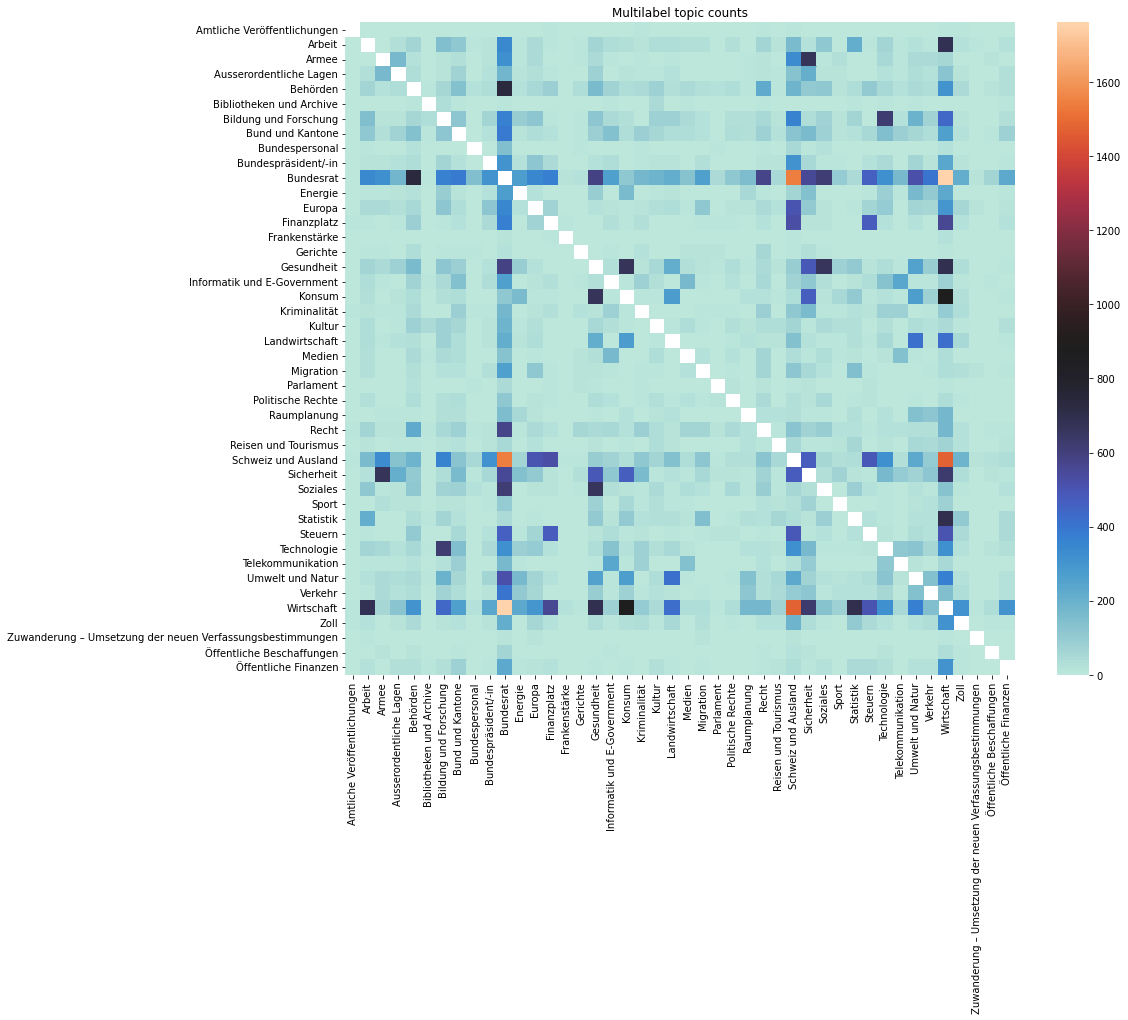

In [ ]:
# Create heatmap
# Darker spots indicate cross-references, i.e. articles of topic X are also classified as topic Y, Z, etc.
# Bundesrat-articles are almost all present in other categories, same for Wirtschaft and Schweiz und Ausland
plt.figure(figsize=(15,12))
ax = sns.heatmap(multilabel_agg_df, cmap='icefire', mask=mask)
plt.title('Multilabel topic absolute overlap')
plt.show()

In [ ]:
# Relative Heatmap
shape = (len(topic_names), len(topic_names))
multilabel_agg = np.zeros(shape, dtype='float')

for idx, topic in enumerate(topic_names):
    multilabel_agg[idx] = multilabel_count_df[multilabel_count_df[topic]==1].sum().values / multilabel_count_df[topic].sum() * 100

In [ ]:
# Create dataframe with topics as index and as columns and number of articles
multilabel_agg_df_rel = pd.DataFrame(multilabel_agg, columns=topic_names, index=topic_names)
multilabel_agg_df_rel

,Amtliche Veröffentlichungen,Arbeit,Armee,Ausserordentliche Lagen,Behörden,Bibliotheken und Archive,Bildung und Forschung,Bund und Kantone,Bundespersonal,Bundespräsident/-in,...,Steuern,Technologie,Telekommunikation,Umwelt und Natur,Verkehr,Wirtschaft,Zoll,Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen,Öffentliche Beschaffungen,Öffentliche Finanzen
Amtliche Veröffentlichungen,100.000000,3.333333,3.333333,10.000000,16.666667,6.666667,6.666667,13.333333,0.000000,3.333333,...,3.333333,6.666667,3.333333,20.000000,6.666667,36.666667,33.333333,3.333333,0.000000,3.333333
Arbeit,0.116144,100.000000,0.696864,3.716609,7.549361,0.232288,16.840883,13.124274,1.277584,1.974448,...,1.393728,7.200929,0.929152,2.787456,1.277584,79.790941,2.787456,0.813008,0.464576,3.135889
Armee,0.080645,0.483871,100.000000,13.467742,2.096774,0.322581,1.612903,2.661290,0.403226,1.290323,...,0.322581,4.435484,0.806452,3.387097,3.790323,4.516129,0.403226,0.080645,1.290323,0.161290
Ausserordentliche Lagen,0.697674,7.441860,38.837209,100.000000,9.302326,0.232558,4.418605,16.279070,0.697674,5.581395,...,1.395349,5.813953,1.860465,8.372093,6.046512,29.302326,3.720930,0.465116,0.465116,7.209302
Behörden,0.466418,6.063433,2.425373,3.731343,100.000000,0.746269,5.690299,12.966418,2.145522,3.731343,...,9.981343,4.850746,2.425373,4.011194,3.264925,28.358209,4.384328,0.373134,1.399254,2.611940
Bibliotheken und Archive,2.500000,2.500000,5.000000,1.250000,10.000000,100.000000,43.750000,8.750000,1.250000,0.000000,...,2.500000,11.250000,7.500000,11.250000,1.250000,5.000000,2.500000,1.250000,0.000000,15.000000
Bildung und Forschung,0.142552,10.334996,1.425517,1.354241,4.347826,2.494654,100.000000,8.481825,0.285103,4.419102,...,0.285103,44.191019,1.853172,13.970064,5.060584,31.860299,0.997862,0.213828,0.427655,2.066999
Bund und Kantone,0.606061,17.121212,5.000000,10.606061,21.060606,1.060606,18.030303,100.000000,0.909091,3.484848,...,7.575758,22.121212,12.727273,8.636364,5.909091,40.454545,3.939394,0.303030,1.515152,12.121212
Bundespersonal,0.000000,5.339806,2.427184,1.456311,11.165049,0.485437,1.941748,2.912621,100.000000,0.000000,...,0.970874,0.970874,0.970874,1.456311,1.941748,10.679612,1.941748,0.000000,1.456311,2.912621
Bundespräsident/-in,0.174825,2.972028,2.797203,4.195804,6.993007,0.000000,10.839161,4.020979,0.000000,100.000000,...,4.720280,7.692308,0.699301,11.188811,3.496503,41.783217,3.496503,0.349650,0.000000,1.748252


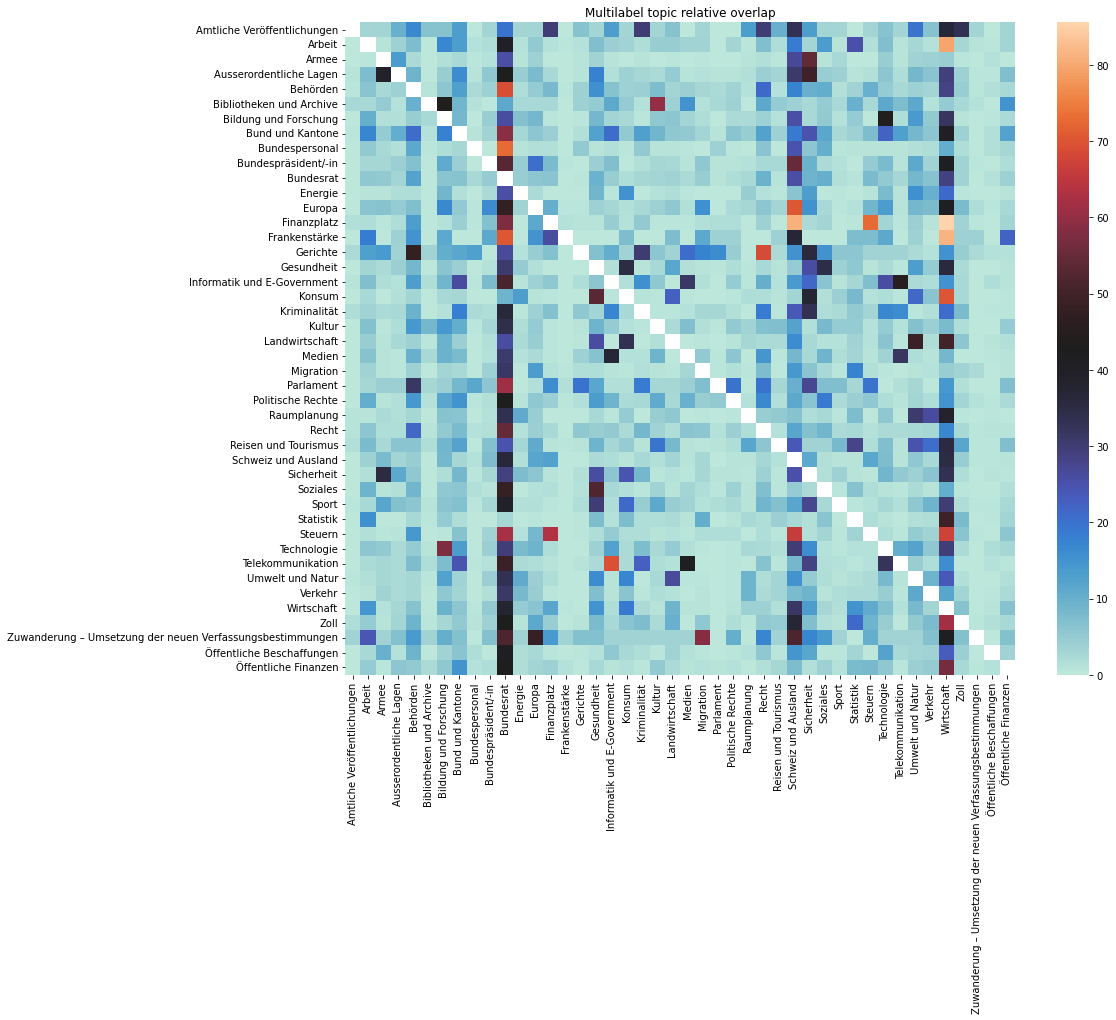

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(multilabel_agg_df_rel, cmap='icefire', mask=mask)
plt.title('Multilabel topic relative overlap')
plt.show()

In [ ]:
# Almost all press releases classified as Bundesrat are also present in other topics
# Only 264 press releases are exclusively classified as Bundesrat
bundesrat_subset_df = multilabel_count_df[multilabel_count_df['Bundesrat']==1]
bundesrat_subset_df[bundesrat_subset_df.sum(axis=1)>1]

,topic_name,Amtliche Veröffentlichungen,Arbeit,Armee,Ausserordentliche Lagen,Behörden,Bibliotheken und Archive,Bildung und Forschung,Bund und Kantone,Bundespersonal,Bundespräsident/-in,...,Steuern,Technologie,Telekommunikation,Umwelt und Natur,Verkehr,Wirtschaft,Zoll,Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen,Öffentliche Beschaffungen,Öffentliche Finanzen
text,published,,,,,,,,,,,,,,,,,,,,,
"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherheit und Menschenrechten"" Rede von Bundespräsidentin Simonetta Sommaruga anlässlich der hochrangigen Woche der 70. Generalversammlung der Vereinten Nationen in New York. – Es gilt das gesprochene Wort.",2015-09-28,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"""Alle rechtsstaatlichen Garantien werden eingehalten"" Besuch bei SoKo Master der Kantonspolizei Zürich; Bundesrätin Karin Keller-Sutter - es gilt das gesprochene Wort",2021-05-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Aussenpolitische Isolation und wirtschaftliche Partizipation - das geht nicht zusammen"" Bundespräsidentin Simonetta Sommaruga. Es gilt das gesprochene Wort.",2015-09-04,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"""Beide Initiativen würden den Wirtschaftsstandort Schweiz zusätzlich belasten"" Medienanlass in Gümligen; Bundesrätin Karin Keller-Sutter - es gilt das gesprochene Wort",2020-10-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
"""Bekämpfung der häuslichen und der sexuellen Gewalt"" Frauensession 2021; Bundesrätin Karin Keller-Sutter - es gilt das gesprochene Wort",2021-10-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"„Die Relevanz der Schweizer Exportwirtschaft“ Ansprache von Bundesrat Guy Parmelin, Vorsteher des Eidgenössischen Departements für Wirtschaft, Bildung und Forschung (WBF) anlässlich des Aussenwirtschaftsforums 2019, Zürich, Dienstag 26. März 2019",2019-03-26,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
"„Erfolgsfaktor Mensch: Wissen, Können und Vertrauen für mehr Zukunft“ Rede von Bundesrat Guy Parmelin, Vorsteher des Eidgenössischen Departements für Wirtschaft, Bildung und Forschung zum Tag der Wirtschaft",2019-11-21,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
„Ma vie de Courgette“ und „Die göttliche Ordnung“ in je drei Kategorien mit dem Schweizer Filmpreis 2017 geehrt Heute Abend sind in Anwesenheit von Bundesrat Alain Berset zum zwanzigsten Mal die Schweizer Filmpreise vergeben worden. Der lange Animationsfilm „Ma vie de Courgette “ und der Spielfilm „Die göttliche Ordnung“ erhielten Trophäen in je drei Kategorien. Der Dokumentarfilm „Cahier africain“ erhielt zwei Trophäen. Die Preisverleihung fand im Bâtiment des Forces Motrices in Genf statt.,2017-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
multilabel_count_df.to_pickle(f'{root_dir}/multilabel_count_df.pkl')
multilabel_agg_df.to_pickle(f'{root_dir}/multilabel_agg_df.pkl')

### 3. Binary classifier
Use press releases of the two largest topics "Wirtschaft" and "Schweiz und Ausland" (except Bundesrat), but exclude releases which are present in both topics (i.e. transform problem to a simple binary classification task) 

In [4]:
multilabel_count_df = pd.read_pickle(f'{root_dir}/multilabel_count_df.pkl')
multilabel_agg_df = pd.read_pickle(f'{root_dir}/multilabel_agg_df.pkl')

In [5]:
class_1 = 'Wirtschaft'
class_2 = 'Schweiz und Ausland'

In [6]:
# Examples only Schweiz und Ausland
multilabel_count_df[(multilabel_count_df[class_1]==0) & (multilabel_count_df[class_2]==1)].reset_index()['text'].iloc[100]

'35. Treffen des Gemischten Landverkehrsausschusses Schweiz–EU Die Delegierten der Schweiz und der Europäischen Union (EU) erörterten am 7. Juni 2019 anlässlich des 35. Treffens des Gemischten Landverkehrsausschusses in Brüssel verschiedene aktuelle Themen im Strassen- und im Schienenverkehr. Zur Berücksichtigung des technischen Fortschritts verabschiedeten sie eine erneute Änderung des Anhangs 1 des Landverkehrsabkommens. Die Anpassungen bewirken namentlich, dass elektrische Fahrzeuge aus Sicherheitsgründen akustisch besser wahrnehmbar und Lastwagen mit dem neuen intelligenten Fahrtschreiber ausgerüstet werden müssen.'

In [7]:
# There are 4672 articles classified as "Wirtschaft"
multilabel_count_df[class_1].sum()

4672

In [8]:
# Many "Wirtschaft" articles are classified in different categories
multilabel_count_df[multilabel_count_df[class_1]==1].sum().sort_values(ascending=False)

topic_name
Wirtschaft                                                   4672
Bundesrat                                                    1761
Schweiz und Ausland                                          1478
Konsum                                                        880
Statistik                                                     695
Gesundheit                                                    688
Arbeit                                                        687
Sicherheit                                                    632
Finanzplatz                                                   558
Steuern                                                       504
Bildung und Forschung                                         447
Landwirtschaft                                                422
Umwelt und Natur                                              375
Technologie                                                   317
Zoll                                                          312

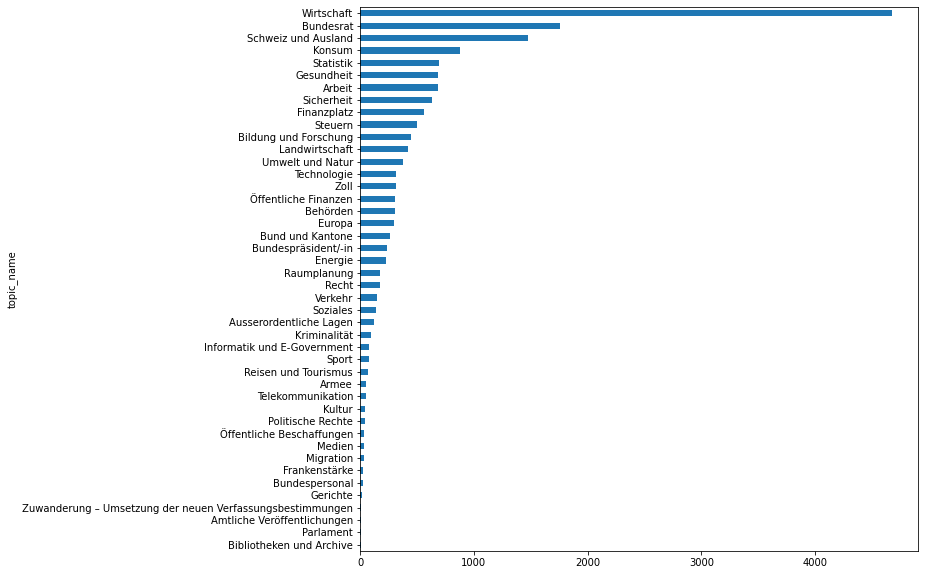

In [9]:
# Messages in category Wirtschaft are also present in following categories
plt.figure(figsize=(10,10))
multilabel_count_df[multilabel_count_df[class_1]==1].sum().sort_values().plot.barh()
plt.show()

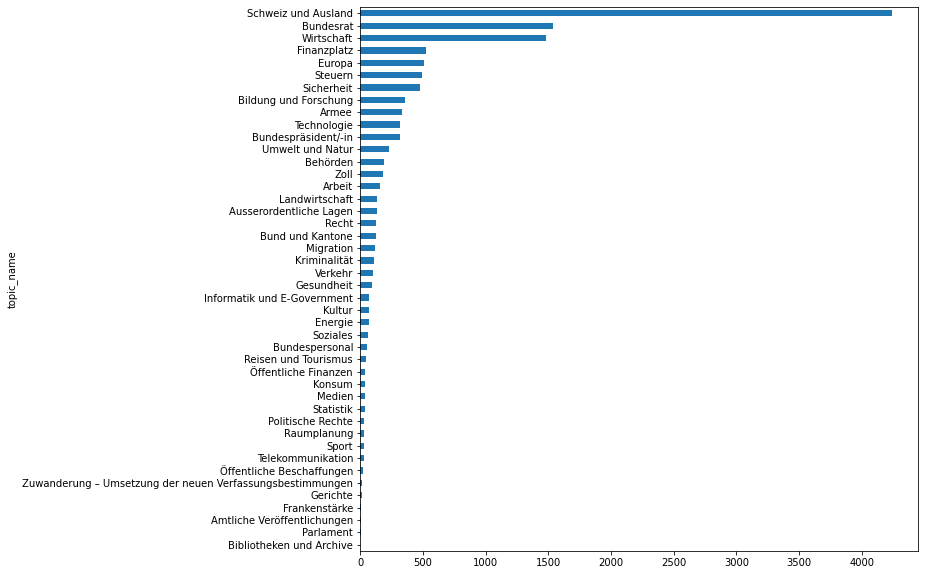

In [10]:
# Messages in category "Schweiz und Ausland" are also present in following categories
plt.figure(figsize=(10,10))
multilabel_count_df[multilabel_count_df[class_2]==1].sum().sort_values().plot.barh()
plt.show()

In [11]:
# Lets look at overlap of biggest categories, besides Bundesrat, i.e. Wirtschaft and Schweiz und Ausland
# Wirtschafts has 4672 unique articles
# Schweiz und Ausland has 4236 unique articles
# 1467 articles are classified as "Wirtschaft" and "Schweiz und Ausland"
multilabel_agg_df.loc[[class_1, class_2]][[class_1, class_2]]

,Wirtschaft,Schweiz und Ausland
Wirtschaft,4672,1478
Schweiz und Ausland,1478,4236


In [12]:
# Examples of multilabel
multilabel_count_df[(multilabel_count_df[class_1]==1) & (multilabel_count_df[class_2]==1)].reset_index()['text'].iloc[0]

'"Schoggigesetz": Aufhebung der Ausfuhrbeiträge per 1. Januar 2019 Die Gesetzesänderungen zur Aufhebung der Ausfuhrbeiträge («Schoggigesetz») treten per 1. Januar 2019 in Kraft. Dies hat der Bundesrat am 21. September 2018 beschlossen. Ausserdem hat er entschieden, Begleitmassnahmen zum Erhalt von Arbeitsplätzen und Wertschöpfung in der Nahrungsmittelproduktion umzusetzen.'

In [13]:
# Examples only Wirtschaft
multilabel_count_df[(multilabel_count_df[class_1]==1) & (multilabel_count_df[class_2]==0)].reset_index()['text'].iloc[100]

'Agroscope wird führungsmässig verschlankt Führung und Forschung sollen bei Agroscope näher zueinander rücken. Deshalb hat Agroscope beschlossen, die Führungsstrukturen zu vereinfachen. Konkret bedeutet dies, dass die heutigen vier Forschungsinstitute und 19 Forschungsbereiche aufgehoben und durch zehn Einheiten ersetzt werden, die künftig die Leistungen von Agroscope erbringen werden. Insgesamt fallen durch diese Reorganisation 14 Stellen im Kader weg.'

In [14]:
# Select only press releases assigned to a single topic
mask = ((multilabel_count_df[class_1]==1) & (multilabel_count_df[class_2]==0)) | ((multilabel_count_df[class_1]==0) & (multilabel_count_df[class_2]==1))
subset_df = multilabel_count_df[mask].reset_index()[['text', class_1, class_2]]
subset_df

topic_name,text,Wirtschaft,Schweiz und Ausland
0,"""'Initiative de Paris pour la paix au Proche-O...",0,1
1,"""110 years of Swiss-Egyptian business relation...",0,1
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",0,1
3,"""A-t-on progressé dans le respect des droits d...",0,1
4,"""Aktuelle europapolitische Themen"" Ansprache v...",0,1
...,...,...,...
5947,"„Politik bedeutet, Zukunft gestalten“ Rappersw...",0,1
5948,„Prendre parti avec cœur pour une Suisse et un...,0,1
5949,„Responding to European uncertainties with a s...,0,1
5950,„Sicherheit Schweiz“ 2015: Der Nachrichtendien...,0,1


In [15]:
# Set label column
subset_df['label'] = subset_df[class_1]
subset_df_sub = subset_df[['text', 'label']].copy()
subset_df_sub['label'] = subset_df_sub['label'].map(lambda x: class_2 if x==0 else class_1)
subset_df_sub

topic_name,text,label
0,"""'Initiative de Paris pour la paix au Proche-O...",Schweiz und Ausland
1,"""110 years of Swiss-Egyptian business relation...",Schweiz und Ausland
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",Schweiz und Ausland
3,"""A-t-on progressé dans le respect des droits d...",Schweiz und Ausland
4,"""Aktuelle europapolitische Themen"" Ansprache v...",Schweiz und Ausland
...,...,...
5947,"„Politik bedeutet, Zukunft gestalten“ Rappersw...",Schweiz und Ausland
5948,„Prendre parti avec cœur pour une Suisse et un...,Schweiz und Ausland
5949,„Responding to European uncertainties with a s...,Schweiz und Ausland
5950,„Sicherheit Schweiz“ 2015: Der Nachrichtendien...,Schweiz und Ausland


In [16]:
ds = Dataset.from_pandas(subset_df_sub)
ds = ds.class_encode_column('label')
ds.features

Casting to class labels:   0%|          | 0/5952 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Schweiz und Ausland', 'Wirtschaft'], id=None)}

In [17]:
model_ckpt = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True)
    tokens['label_name'] = ds.features['label'].int2str(batch['label']) # Get label names
    return tokens
    
ds = ds.map(tokenize, batched=True)
ds.features

Map:   0%|          | 0/5952 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Schweiz und Ausland', 'Wirtschaft'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'label_name': Value(dtype='string', id=None)}

In [19]:
# Train, test valid split
# See https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2
test_trainvalid = ds.train_test_split(test_size=0.1, stratify_by_column='label')
train_valid = test_trainvalid['train'].train_test_split(test_size=0.2, stratify_by_column='label')

ds_split = DatasetDict({
    'train': train_valid['train'],
    'valid': train_valid['test'],
    'test': test_trainvalid['test']
})

ds_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'label_name'],
        num_rows: 4284
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'label_name'],
        num_rows: 1072
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'label_name'],
        num_rows: 596
    })
})

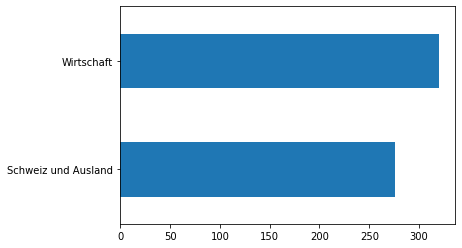

In [20]:
ds_split.set_format('pandas')
ds_split['test']['label_name'].value_counts(ascending=True).plot.barh()
plt.show()

In [21]:
ds_split.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
num_labels = len(ds.features['label'].names)
num_labels

2

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [26]:
batch_size = 32
model_name = 'binary_classification'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=len(ds_split['train']) // batch_size)

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_split['train'],
                  eval_dataset=ds_split['valid'],
                  tokenizer=tokenizer)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, label_name. If text, label_name are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4284
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 268
  Number of trainable parameters = 109082882
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is fa

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.178000,0.107480,0.963619,0.963622
2,0.045100,0.142595,0.962687,0.962670


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, label_name. If text, label_name are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1072
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, label_name. If text, label_name are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1072
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=268, training_loss=0.11096167314186026, metrics={'train_runtime': 110.1908, 'train_samples_per_second': 77.756, 'train_steps_per_second': 2.432, 'total_flos': 1219532074924320.0, 'train_loss': 0.11096167314186026, 'epoch': 2.0})

In [27]:
pred_test = trainer.predict(ds_split['test'])
pred_test.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, label_name. If text, label_name are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 596
  Batch size = 32


{'test_loss': 0.14161895215511322,
 'test_accuracy': 0.9664429530201343,
 'test_f1': 0.966450928054782,
 'test_runtime': 2.2375,
 'test_samples_per_second': 266.364,
 'test_steps_per_second': 8.491}

In [28]:
pred_test.predictions

array([[ 3.521726 , -3.1207044],
       [ 3.6236684, -3.053064 ],
       [ 3.7442427, -3.3423507],
       ...,
       [ 3.9088964, -3.5812323],
       [-4.0534973,  3.95418  ],
       [-2.9358706,  3.0857217]], dtype=float32)

In [29]:
y_pred = np.argmax(pred_test.predictions, axis=1)
y_pred

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,

In [30]:
y_true = pred_test.label_ids
y_true

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,

In [31]:
label_names = ds.features['label'].names

In [32]:
print(classification_report(y_true, y_pred, target_names=label_names))

                     precision    recall  f1-score   support

Schweiz und Ausland       0.96      0.97      0.96       276
         Wirtschaft       0.97      0.97      0.97       320

           accuracy                           0.97       596
          macro avg       0.97      0.97      0.97       596
       weighted avg       0.97      0.97      0.97       596



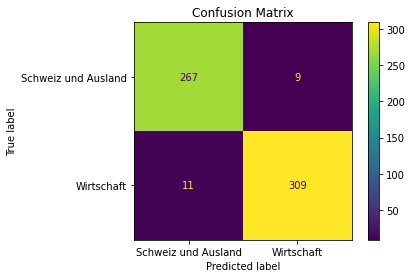

In [33]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Let's look at some that are classified as "Schweiz und Ausland" instead of "Wirtschaft"
idxs = []

for idx, (pred, true) in enumerate(zip(list(y_pred), list(y_true))):
  if pred==0 and true==1:
    idxs.append(idx)

In [35]:
ds_split['test'].set_format('pandas')

for idx in idxs:
  print(ds_split['test'][idx]['text'].values)

['Neue Impulse für die Beziehungen zwischen der Schweiz und Argentinien Bundespräsidentin Doris Leuthard hat sich im Rahmen ihres offiziellen Besuchs in Argentinien am Dienstag, 18. April 2017, in Buenos Aires mit Präsident Mauricio Macri getroffen. Sie vereinbarten, die traditionsreichen Beziehungen zwischen der Schweiz und Argentinien in Wirtschaft und Handel sowie weiteren Bereichen zu intensivieren. Dazu verabschiedeten sie eine gemeinsame Präsidialerklärung, die als Roadmap zur Vertiefung der weiteren Zusammenarbeit dient. Die Verhandlungen für ein Freihandelsabkommen EFTA-Mercosur sollen in der ersten Jahreshälfte starten.']
['Peter Gasser wird Botschafter Der Bundesrat hat am 23. November 2016 Peter Gasser den Titel als Botschafter verliehen.']
['Bundesrat wählt Philippe Egger zum Vizepräsidenten des FINMA-Verwaltungsrates Der Bundesrat hat an seiner heutigen Sitzung Philippe Egger für die neue Amtsperiode 2016 – 2019 zum Vizepräsidenten des Verwaltungsrates der Eidgenössischen 

In [38]:
# This shows that assigning a press release to a topic is highly subjectiv, especially when 44 topics are available...
# Looking at such "wrongly" classified examples shows, that maybe the ground truth is wrong and should be changed
# E.g. it is not clear why following example is classified as Wirtschaft
entries_flat_df[entries_flat_df['text']=='Peter Gasser wird Botschafter Der Bundesrat hat am 23. November 2016 Peter Gasser den Titel als Botschafter verliehen.']

,title,summary,text,text_len,author,published,link,topic,topic_name
719,Peter Gasser wird Botschafter,Der Bundesrat hat am 23. November 2016 Peter G...,Peter Gasser wird Botschafter Der Bundesrat ha...,118,Der Bundesrat,2016-11-23,https://www.admin.ch/gov/de/start/dokumentatio...,2,Arbeit
10560,Peter Gasser wird Botschafter,Der Bundesrat hat am 23. November 2016 Peter G...,Peter Gasser wird Botschafter Der Bundesrat ha...,118,Der Bundesrat,2016-11-23,https://www.admin.ch/gov/de/start/dokumentatio...,10,Bundesrat
42498,Peter Gasser wird Botschafter,Der Bundesrat hat am 23. November 2016 Peter G...,Peter Gasser wird Botschafter Der Bundesrat ha...,118,Der Bundesrat,2016-11-23,https://www.admin.ch/gov/de/start/dokumentatio...,47,Wirtschaft


In [39]:
# Save model
trainer.save_model(root_dir+'/'+model_name)

Saving model checkpoint to drive/MyDrive/medienmitteilungen/binary_classification
Configuration saved in drive/MyDrive/medienmitteilungen/binary_classification/config.json
Model weights saved in drive/MyDrive/medienmitteilungen/binary_classification/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/medienmitteilungen/binary_classification/tokenizer_config.json
Special tokens file saved in drive/MyDrive/medienmitteilungen/binary_classification/special_tokens_map.json


### 4. Multi-label classifier with two topics
Use the two topics from the simple binary classifier, but this time with all press releases and formulated as a multi-label classification problem

In [40]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True)
    return tokens

In [41]:
label_names = ['Wirtschaft', 
               'Schweiz und Ausland']

cols = ['text'] + label_names
cols

['text', 'Wirtschaft', 'Schweiz und Ausland']

In [42]:
num_labels = len(label_names)
num_labels

2

In [43]:
subset_multi_df = multilabel_count_df[multilabel_count_df[label_names]==1].reset_index().fillna(0.0)[cols]
subset_multi_df = subset_multi_df[subset_multi_df[label_names].sum(axis=1)>0] # Only message where at least one of the required labels is set
subset_multi_df.head()

topic_name,text,Wirtschaft,Schweiz und Ausland
0,"""'Initiative de Paris pour la paix au Proche-O...",0.0,1.0
1,"""110 years of Swiss-Egyptian business relation...",0.0,1.0
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",0.0,1.0
3,"""A-t-on progressé dans le respect des droits d...",0.0,1.0
4,"""Aktuelle europapolitische Themen"" Ansprache v...",0.0,1.0


In [44]:
# 1478 press releases are assigned to both topics, see also EDA
subset_multi_df[label_names].sum(axis=1).value_counts().sort_index()

1.0    5952
2.0    1478
dtype: int64

In [45]:
ds = Dataset.from_pandas(subset_multi_df)
ds

Dataset({
    features: ['text', 'Wirtschaft', 'Schweiz und Ausland', '__index_level_0__'],
    num_rows: 7430
})

In [46]:
# create one hot label column
# see https://colab.research.google.com/drive/1aue7x525rKy6yYLqqt-5Ll96qjQvpqS7
cols = ds.column_names
ds = ds.map(lambda x : {'labels': [x[c] for c in cols if c in label_names]})
ds

Map:   0%|          | 0/7430 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'Wirtschaft', 'Schweiz und Ausland', '__index_level_0__', 'labels'],
    num_rows: 7430
})

In [47]:
# Label column
ds[0]

{'text': '"\'Initiative de Paris pour la paix au Proche-Orient" (fr) Paris, 03.05.2016: Statement von Bundesrat Didier Burkhalter anlässlich des Ministertreffens - Es gilt das gesprochen Wort',
 'Wirtschaft': 0.0,
 'Schweiz und Ausland': 1.0,
 '__index_level_0__': 0,
 'labels': [0.0, 1.0]}

In [48]:
# Load model and tokenizer as multi-label problem
model_ckpt = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type='multi_label_classification') # see: https://discuss.huggingface.co/t/fine-tune-for-multiclass-or-multilabel-multiclass/4035/20?page=2

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf014

In [49]:
ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/7430 [00:00<?, ? examples/s]

In [50]:
# Train/Valid/Test-split
test_trainvalid = ds.train_test_split(test_size=0.1)
train_valid = test_trainvalid['train'].train_test_split(test_size=0.1)

ds_split = DatasetDict({
    'train': train_valid['train'],
    'valid': train_valid['test'],
    'test': test_trainvalid['test']
})

ds_split

DatasetDict({
    train: Dataset({
        features: ['text', 'Wirtschaft', 'Schweiz und Ausland', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6018
    })
    valid: Dataset({
        features: ['text', 'Wirtschaft', 'Schweiz und Ausland', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 669
    })
    test: Dataset({
        features: ['text', 'Wirtschaft', 'Schweiz und Ausland', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 743
    })
})

In [51]:
ds_split.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [52]:
# Problem type multi_label_classification uses loss BCEWithLogitsLoss()
# BCEWithLogitsLoss() uses logits, which we turn into probs by applying sigmoid for evaluation and applying threshold, see https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/20
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, problem_type='multi_label_classification').to(device) # see https://discuss.huggingface.co/t/fine-tune-for-multiclass-or-multilabel-multiclass/4035/20?page=2

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fe

In [53]:
def compute_metrics(pred):
  labels = pred.label_ids.astype(int)
  preds = pred.predictions
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(preds)) # see https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
  preds_thresh = np.zeros(probs.shape)
  preds_thresh[np.where(probs >= 0.5)] = 1
  acc = accuracy_score(labels, preds_thresh) # IMPORTANT: THIS CALCULATES THE EXACT SUBSET ACCURACY (i.e. only exact matches of all topics count as positiv), WHICH IS A VERY STRICT PERFORMANCE METRIC FOR MULTI-LABEL, see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  f1 = f1_score(labels, preds_thresh, average='weighted')
  return {'accuracy': acc, 'f1': f1}

In [54]:
batch_size = 32
model_name = 'multi_label_small'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=len(ds_split['train']) // batch_size)

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_split['train'],
                  eval_dataset=ds_split['valid'],
                  tokenizer=tokenizer)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, Wirtschaft, Schweiz und Ausland. If text, __index_level_0__, Wirtschaft, Schweiz und Ausland are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num e

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.244700,0.199898,0.868460,0.939812
2,0.117900,0.198256,0.856502,0.936669
3,0.066600,0.250518,0.860987,0.940124
4,0.038200,0.275113,0.862481,0.939506
5,0.018900,0.290094,0.865471,0.941034


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, Wirtschaft, Schweiz und Ausland. If text, __index_level_0__, Wirtschaft, Schweiz und Ausland are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 669
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, Wirtschaft, Schweiz und Ausland. If text, __index_level_0__, Wirtschaft, Schweiz und Ausland are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 669
  Batch size = 32
Saving model checkpoint to multi_label_small/checkpoint-500
Configuration saved in multi_label_small/checkpoint-500/config.json
Model we

TrainOutput(global_step=945, training_loss=0.09681430312376174, metrics={'train_runtime': 365.3181, 'train_samples_per_second': 82.367, 'train_steps_per_second': 2.587, 'total_flos': 4282567175891880.0, 'train_loss': 0.09681430312376174, 'epoch': 5.0})

In [55]:
pred_test = trainer.predict(ds_split['test'])
pred_test.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, Wirtschaft, Schweiz und Ausland. If text, __index_level_0__, Wirtschaft, Schweiz und Ausland are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 743
  Batch size = 32


{'test_loss': 0.2737298309803009,
 'test_accuracy': 0.8855989232839838,
 'test_f1': 0.9431735675996684,
 'test_runtime': 2.8159,
 'test_samples_per_second': 263.857,
 'test_steps_per_second': 8.523}

In [56]:
y_pred = pred_test.predictions
y_pred

array([[ 8.007443 , -2.1277688],
       [ 2.4847808,  6.489169 ],
       [ 7.206231 , -6.986938 ],
       ...,
       [ 7.3186626, -6.8418646],
       [ 7.29644  , -6.5037403],
       [ 7.1489644, -7.1183863]], dtype=float32)

In [57]:
# Transform prediction to probabilities and then use threshold
# see: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(y_pred)) # see https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
y_pred_thresh = np.zeros(probs.shape)
y_pred_thresh[np.where(probs >= 0.5)] = 1
y_pred_thresh

array([[1., 0.],
       [1., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [58]:
y_true = pred_test.label_ids.astype(int)
y_true

array([[1, 1],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 1],
       [1, 0]])

In [59]:
cm = multilabel_confusion_matrix(y_true, y_pred_thresh)
cm.shape

(2, 2, 2)

In [60]:
cm[0] # Wirtschaft

array([[253,  26],
       [ 25, 439]])

See explaination: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html

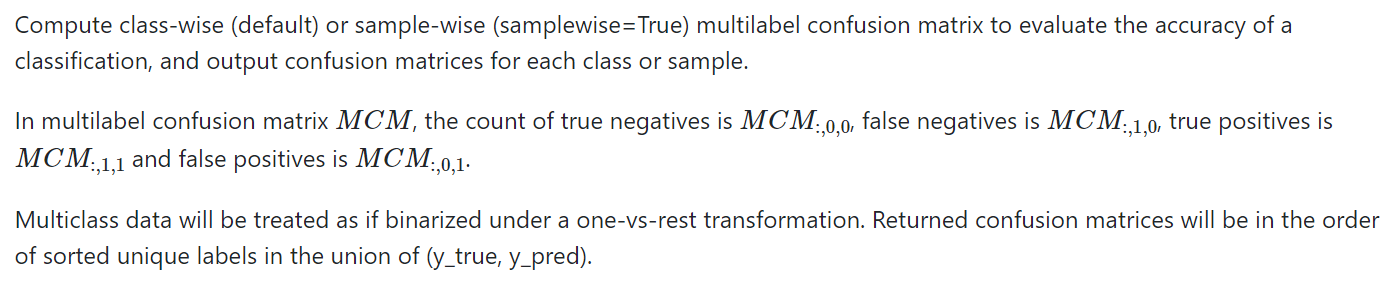

In [61]:
print(classification_report(y_true, y_pred_thresh, target_names=label_names))

                     precision    recall  f1-score   support

         Wirtschaft       0.94      0.95      0.95       464
Schweiz und Ausland       0.93      0.95      0.94       419

          micro avg       0.94      0.95      0.94       883
          macro avg       0.94      0.95      0.94       883
       weighted avg       0.94      0.95      0.94       883
        samples avg       0.95      0.96      0.95       883



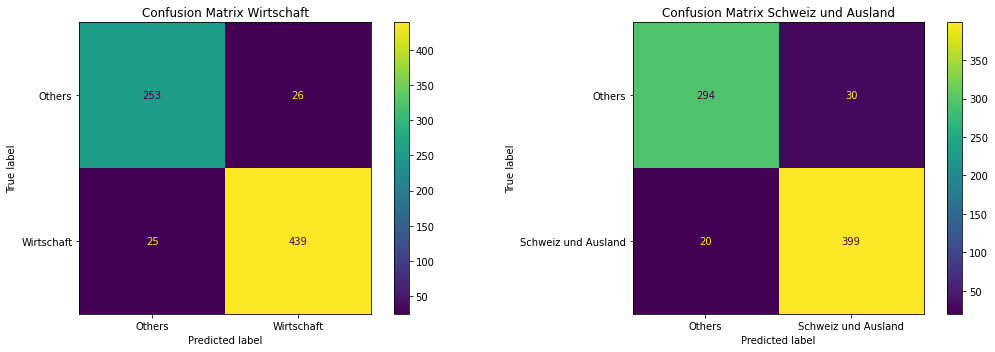

In [62]:
# Create ConfusionMatrix for each class
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for idx, (label, ax) in enumerate(zip(label_names, axs.ravel())):
  ConfusionMatrixDisplay(cm[idx], display_labels=['Others', label_names[idx]]).plot(ax=ax)
  ax.set_title(f'Confusion Matrix {label_names[idx]}')

fig.tight_layout()
plt.show()

In [63]:
# Let's look at an example that is classified as both, but predicted as only one
idxs = []

for idx, (pred, true) in enumerate(zip(list(y_pred_thresh), list(y_true))):
  if np.sum(true)==2 and np.sum(pred)!=2:
    idxs.append(idx)

In [64]:
ds_split['test'].set_format('pandas')

for idx in idxs:
  print(ds_split['test'][idx]['text'].values)

['Bundesrat will die OECD-Leitsätze für multinationale Unternehmen aktualisieren Der Bundesrat hat am 22. Juni 2022 das Verhandlungsmandat für die Aktualisierung der OECD-Leitsätze für multinationale Unternehmen genehmigt. Die Schweiz wird sich insbesondere dafür einsetzen, dass dieser Verhaltenskodex für verantwortungsvolle Unternehmensführung in den Bereichen Digitalisierung und Umwelt angepasst wird.']
['Frankenstärke: Bundesrat Schneider-Ammann empfängt Vertreter der Landwirtschaft und der Lebensmittelindustrie Auf Einladung von Bundesrat Johann N. Schneider-Ammann hat heute einen Austausch zur Landwirtschaft zur Frankenstärke stattgefunden. Der Vorsteher des Eidgenössischen Departements für Wirtschaft, Bildung und Forschung WBF versammelte die Spitzen der wichtigsten landwirtschaftlichen Verbände und Repräsentanten der Lebensmittelindustrie. Die Diskussion über die Zukunftsperspektiven der Land- und Ernährungswirtschaft stand im Zentrum des Anlasses.']
['Bundesrat verabschiedet Bo

In [65]:
# Save model
trainer.save_model(root_dir+'/'+model_name)

Saving model checkpoint to drive/MyDrive/medienmitteilungen/multi_label_small
Configuration saved in drive/MyDrive/medienmitteilungen/multi_label_small/config.json
Model weights saved in drive/MyDrive/medienmitteilungen/multi_label_small/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/medienmitteilungen/multi_label_small/tokenizer_config.json
Special tokens file saved in drive/MyDrive/medienmitteilungen/multi_label_small/special_tokens_map.json


### 5. Multi-label classifier with topics with > 1200 press releases

In [66]:
label_names = ['Bundesrat',
               'Wirtschaft', 
               'Schweiz und Ausland',
               'Gesundheit',
               'Sicherheit',
               'Umwelt und Natur',
               'Statistik',
               'Bildung und Forschung',
               'Verkehr',
               'Soziales',
               'Konsum',
               'Armee']

cols = ['text'] + label_names
cols

['text',
 'Bundesrat',
 'Wirtschaft',
 'Schweiz und Ausland',
 'Gesundheit',
 'Sicherheit',
 'Umwelt und Natur',
 'Statistik',
 'Bildung und Forschung',
 'Verkehr',
 'Soziales',
 'Konsum',
 'Armee']

In [67]:
label2id = {k:v for v, k in enumerate(label_names)}
label2id

{'Bundesrat': 0,
 'Wirtschaft': 1,
 'Schweiz und Ausland': 2,
 'Gesundheit': 3,
 'Sicherheit': 4,
 'Umwelt und Natur': 5,
 'Statistik': 6,
 'Bildung und Forschung': 7,
 'Verkehr': 8,
 'Soziales': 9,
 'Konsum': 10,
 'Armee': 11}

In [68]:
id2label = {v:k for v, k in enumerate(label_names)}
id2label

{0: 'Bundesrat',
 1: 'Wirtschaft',
 2: 'Schweiz und Ausland',
 3: 'Gesundheit',
 4: 'Sicherheit',
 5: 'Umwelt und Natur',
 6: 'Statistik',
 7: 'Bildung und Forschung',
 8: 'Verkehr',
 9: 'Soziales',
 10: 'Konsum',
 11: 'Armee'}

In [69]:
num_labels = len(label_names)
num_labels

12

In [70]:
subset_multi_df = multilabel_count_df[multilabel_count_df[label_names]==1].reset_index().fillna(0.0)[cols]
subset_multi_df = subset_multi_df[subset_multi_df[label_names].sum(axis=1)>0] # Only message where at least one of the required labels is set
subset_multi_df.head()

topic_name,text,Bundesrat,Wirtschaft,Schweiz und Ausland,Gesundheit,Sicherheit,Umwelt und Natur,Statistik,Bildung und Forschung,Verkehr,Soziales,Konsum,Armee
0,"""'Initiative de Paris pour la paix au Proche-O...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""110 years of Swiss-Egyptian business relation...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"""A-t-on progressé dans le respect des droits d...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"""Aktuelle europapolitische Themen"" Ansprache v...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# 7135 of 15311 press releases have only one label in this subset of topics (assignments to topics not in subset are not considered)
subset_multi_df[label_names].sum(axis=1).value_counts().sort_index()

1.0     7135
2.0     4838
3.0     2182
4.0      960
5.0      169
6.0       20
7.0        6
10.0       1
dtype: int64

In [72]:
ds = Dataset.from_pandas(subset_multi_df)
ds

Dataset({
    features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', '__index_level_0__'],
    num_rows: 15311
})

In [73]:
ds[12]

{'text': '"CORONA 20": Armee-Einsatz offiziell beendet Der vom Bundesrat angeordnete Assistenzdienst-Einsatz der Schweizer Armee im Rahmen der Corona-Pandemie endet heute Dienstag, 30. Juni 2020, nach 107 Tagen. Die letzten noch im Einsatz stehenden Angehörigen der Armee (AdA) werden heute von ihren Aufgaben entbunden und entlassen.',
 'Bundesrat': 0.0,
 'Wirtschaft': 0.0,
 'Schweiz und Ausland': 0.0,
 'Gesundheit': 0.0,
 'Sicherheit': 1.0,
 'Umwelt und Natur': 0.0,
 'Statistik': 0.0,
 'Bildung und Forschung': 0.0,
 'Verkehr': 0.0,
 'Soziales': 0.0,
 'Konsum': 0.0,
 'Armee': 1.0,
 '__index_level_0__': 12}

In [74]:
# create one hot label column
cols = ds.column_names
ds = ds.map(lambda x : {'labels': [x[c] for c in cols if c in label_names]})
ds

Map:   0%|          | 0/15311 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', '__index_level_0__', 'labels'],
    num_rows: 15311
})

In [75]:
# Load model and tokenizer as multi-label problem
model_ckpt = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type='multi_label_classification') # see: https://discuss.huggingface.co/t/fine-tune-for-multiclass-or-multilabel-multiclass/4035/20?page=2

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf014

In [76]:
ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/15311 [00:00<?, ? examples/s]

In [77]:
# Train/Valid/Test-split
test_trainvalid = ds.train_test_split(test_size=0.1)
train_valid = test_trainvalid['train'].train_test_split(test_size=0.1)

ds_split = DatasetDict({
    'train': train_valid['train'],
    'valid': train_valid['test'],
    'test': test_trainvalid['test']
})

ds_split

DatasetDict({
    train: Dataset({
        features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12401
    })
    valid: Dataset({
        features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1378
    })
    test: Dataset({
        features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     

In [78]:
ds_split.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [79]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           problem_type='multi_label_classification').to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Bundesrat",
    "1": "Wirtschaft",
    "2": "Schweiz und Ausland",
    "3": "Gesundheit",
    "4": "Sicherheit",
    "5": "Umwelt und Natur",
    "6": "Statistik",
    "7": "Bildung und Forschung",
    "8": "Verkehr",
    "9": "Soziales",
    "10": "Konsum",
    "11": "Armee"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Armee": 11,
    "Bildung und Forschung": 7,
    "Bundesrat": 0,
    "Gesundheit": 3,
    "Konsum": 10,
    "Schweiz und Ausland": 2,
    "Sicherheit": 4,
    "Soziales": 9,


In [80]:
ds_split['train'][0]

{'labels': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'input_ids': tensor([    3, 16874,    91,  8032,  4867,  3285,  7481, 26902,  3069, 26918,
          1656, 26914,  1294, 26914,  3265, 26935, 16874,    21,  8032,  4867,
          3285,  7481,    21,   476,    50,    21,  3927,  4224, 19121,   807,
         11823,  1443,    42, 11823,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0

In [81]:
batch_size = 32
model_name = 'multi_label_medium'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=len(ds_split['train']) // batch_size)

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_split['train'],
                  eval_dataset=ds_split['valid'],
                  tokenizer=tokenizer)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat. If Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implement

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.191000,0.132478,0.613208,0.849313
2,0.108900,0.113497,0.666183,0.867756
3,0.080300,0.110660,0.670537,0.869110


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat. If Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1378
  Batch size = 32
Saving model checkpoint to multi_label_medium/checkpoint-500
Configuration saved in multi_label_medium/checkpoint-500/config.json
Model weights saved in multi_label_medium/checkpoint-500/pytorch_model.bin
tokenizer config file saved in multi_label_medium/checkpoint-500/tokenizer_config.json
Special tokens file saved in mult

TrainOutput(global_step=1164, training_loss=0.12660857155611835, metrics={'train_runtime': 490.5094, 'train_samples_per_second': 75.846, 'train_steps_per_second': 2.373, 'total_flos': 5741939435504760.0, 'train_loss': 0.12660857155611835, 'epoch': 3.0})

In [82]:
pred_test = trainer.predict(ds_split['test'])
pred_test.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat. If Sicherheit, Statistik, text, Wirtschaft, Soziales, Verkehr, Armee, __index_level_0__, Umwelt und Natur, Schweiz und Ausland, Konsum, Bildung und Forschung, Gesundheit, Bundesrat are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1532
  Batch size = 32


{'test_loss': 0.11313386261463165,
 'test_accuracy': 0.6697127937336814,
 'test_f1': 0.866657798211732,
 'test_runtime': 6.279,
 'test_samples_per_second': 243.987,
 'test_steps_per_second': 7.645}

In [83]:
y_pred = pred_test.predictions
y_pred

array([[-3.1016228, -2.4962814,  3.5070012, ..., -4.400697 , -3.926792 ,
        -3.972346 ],
       [-4.500218 ,  2.8449638, -4.1478376, ..., -4.750216 , -3.9379072,
        -4.8079414],
       [ 1.538943 , -4.2523518,  3.3586674, ..., -5.4922624, -6.039875 ,
        -3.6464243],
       ...,
       [-3.5332456, -4.427985 , -4.3476963, ..., -1.3719397, -4.009116 ,
         0.8216822],
       [-3.5727837,  3.6958592, -3.8973248, ..., -3.994359 ,  3.430636 ,
        -3.4044526],
       [-5.2970223, -2.203368 , -4.0834746, ..., -4.638388 , -2.1868682,
        -3.2130473]], dtype=float32)

In [84]:
# Transform prediction to probabilities and then use threshold
# see: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(y_pred)) # see https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
y_pred_thresh = np.zeros(probs.shape)
y_pred_thresh[np.where(probs >= 0.5)] = 1
y_pred_thresh

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
probs

tensor([[0.0430, 0.0761, 0.9709,  ..., 0.0121, 0.0193, 0.0185],
        [0.0110, 0.9451, 0.0156,  ..., 0.0086, 0.0191, 0.0081],
        [0.8233, 0.0140, 0.9664,  ..., 0.0041, 0.0024, 0.0254],
        ...,
        [0.0284, 0.0118, 0.0128,  ..., 0.2023, 0.0178, 0.6946],
        [0.0273, 0.9758, 0.0199,  ..., 0.0181, 0.9686, 0.0322],
        [0.0050, 0.0994, 0.0166,  ..., 0.0096, 0.1009, 0.0387]])

In [86]:
y_true = pred_test.label_ids.astype(int)
y_true

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [87]:
cm = multilabel_confusion_matrix(y_true, y_pred_thresh)
cm[0] # Confusion matrix Bundesrat

array([[862,  54],
       [ 26, 590]])

In [88]:
print(classification_report(y_true, y_pred_thresh, target_names=label_names))

                       precision    recall  f1-score   support

            Bundesrat       0.92      0.96      0.94       616
           Wirtschaft       0.92      0.88      0.90       461
  Schweiz und Ausland       0.88      0.86      0.87       394
           Gesundheit       0.94      0.85      0.89       206
           Sicherheit       0.77      0.62      0.69       182
     Umwelt und Natur       0.83      0.78      0.81       162
            Statistik       0.85      0.90      0.88       145
Bildung und Forschung       0.88      0.83      0.85       150
              Verkehr       0.91      0.82      0.86       142
             Soziales       0.85      0.75      0.79       142
               Konsum       0.88      0.75      0.81       140
                Armee       0.88      0.85      0.87       118

            micro avg       0.89      0.85      0.87      2858
            macro avg       0.88      0.82      0.85      2858
         weighted avg       0.89      0.85      0.87 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


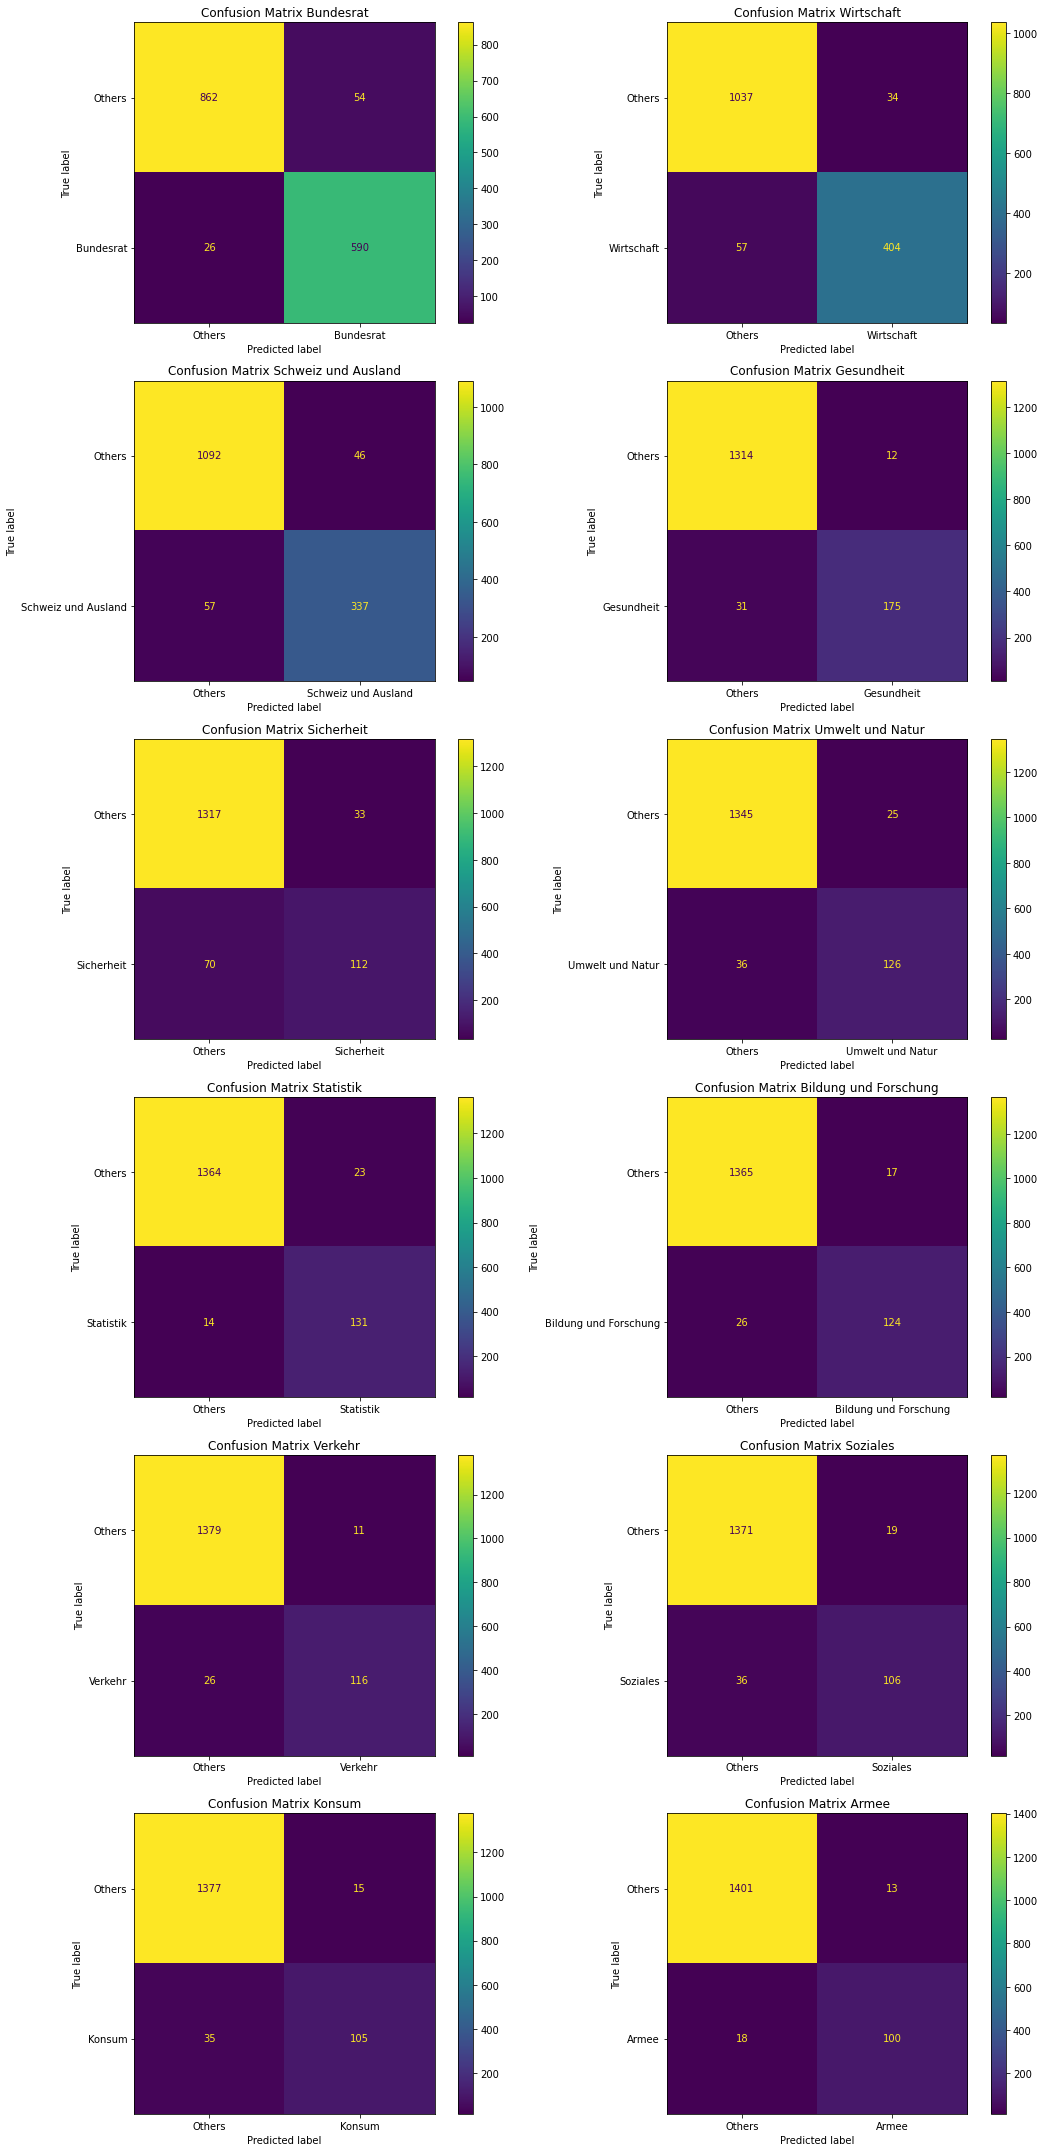

In [89]:
# Create ConfusionMatrix for each class
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15,30))

for idx, (label, ax) in enumerate(zip(label_names, axs.ravel())):
  ConfusionMatrixDisplay(cm[idx], display_labels=['Others', label_names[idx]]).plot(ax=ax)
  ax.set_title(f'Confusion Matrix {label_names[idx]}')

fig.tight_layout()
plt.show()

<ipython-input-90-d81170bdf905>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(fpr[idx_threshold], tpr[idx_threshold], 'bo', color='red')
<ipython-input-90-d81170bdf905>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(fpr[idx_threshold], tpr[idx_threshold], 'bo', color='red')
<ipython-input-90-d81170bdf905>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(fpr[idx_threshold], tpr[idx_threshold], 'bo', color='red')
<ipython-input-90-d81170bdf905>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(fpr[idx_thr

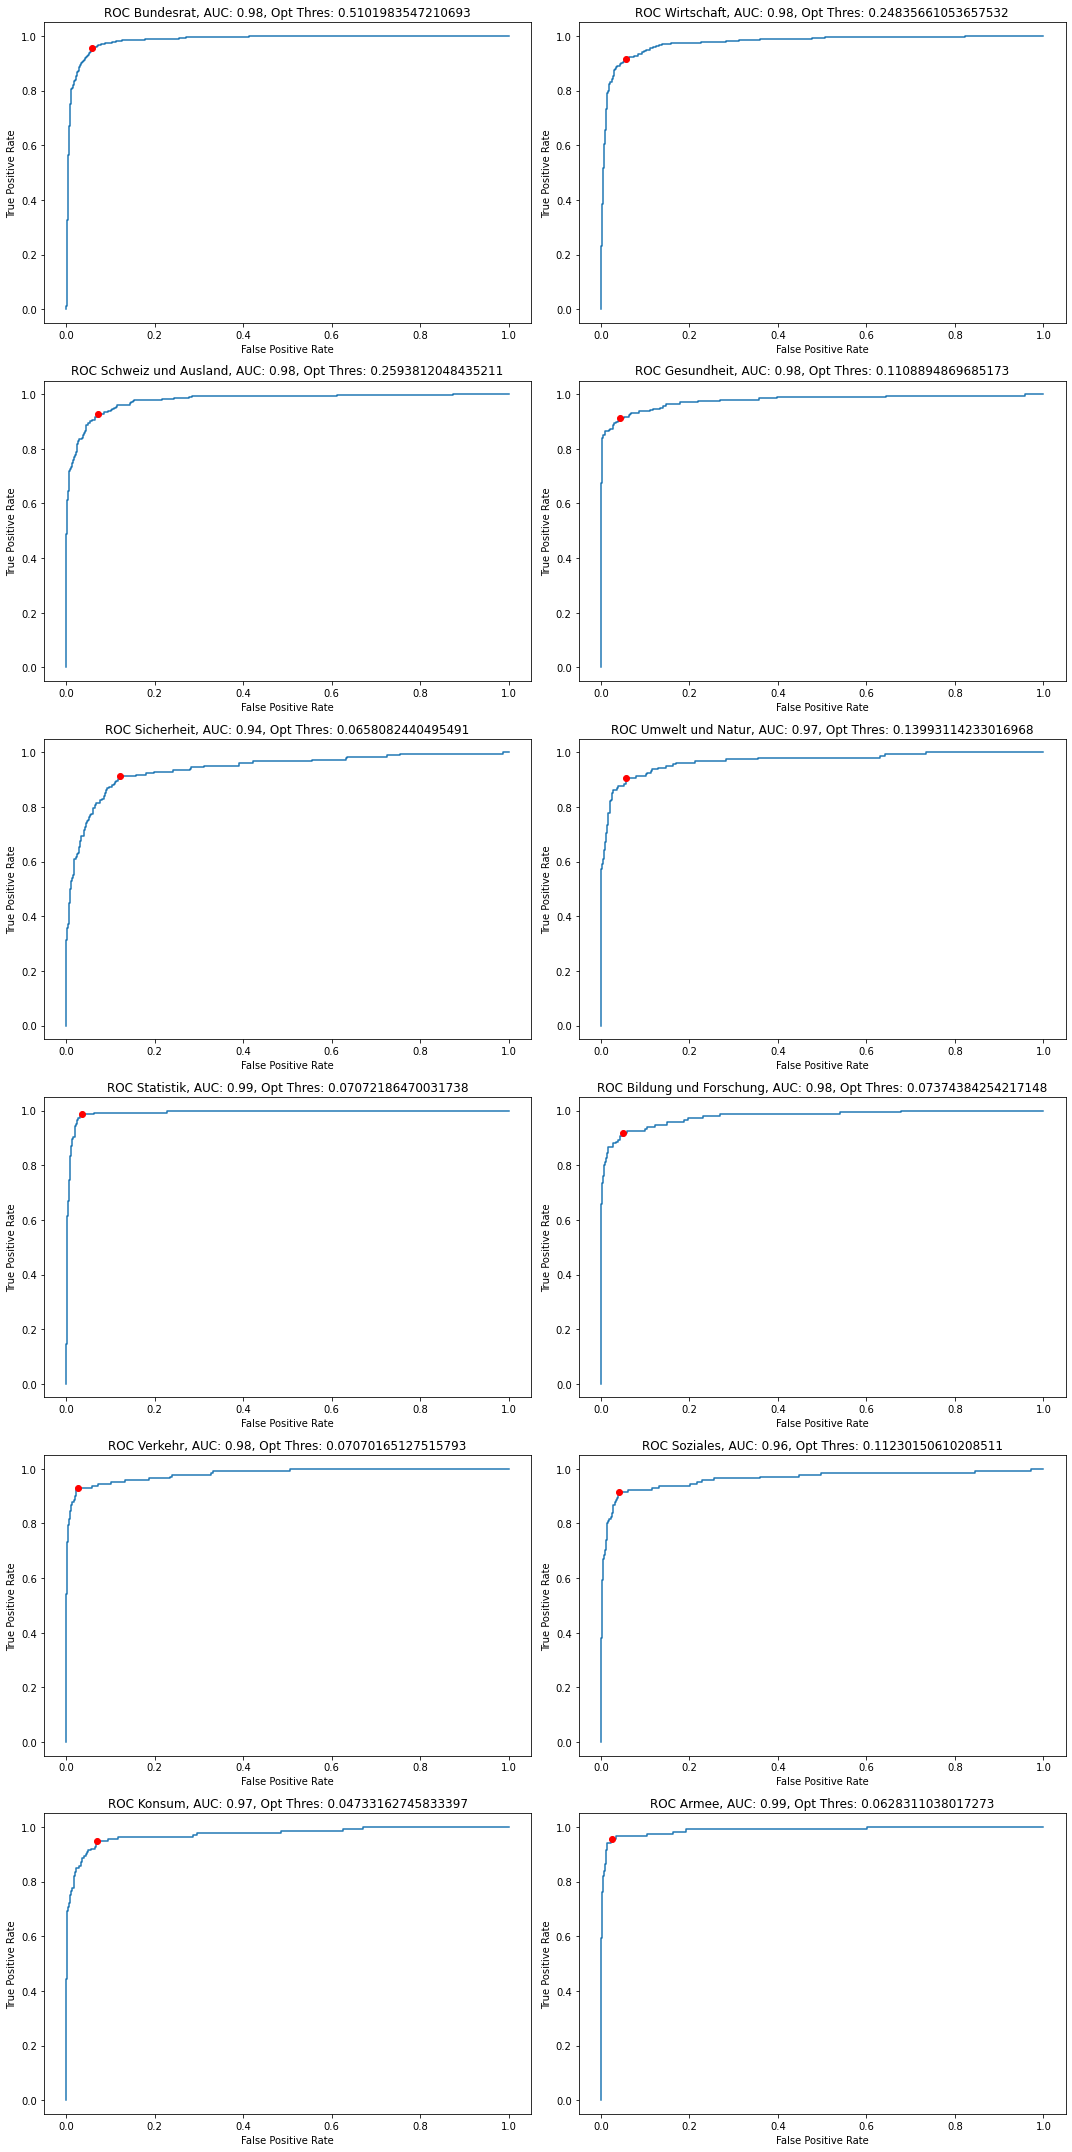

In [90]:
# Create ROC Plots for all classes
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15,30))

for idx, (label, ax) in enumerate(zip(label_names, axs.ravel())):

  # Calc ROC values
  roc = roc_curve(y_true[:,idx], probs.numpy()[:,idx])
  fpr = roc[0]
  tpr = roc[1]
  thresholds = roc[2]

  # Calc AUC score
  auc = round(roc_auc_score(y_true[:,idx], probs.numpy()[:,idx]), 2)

  # Optimal threshold, Youden Index (Youden J)
  idx_threshold = np.argmax(tpr - fpr)
  opt_thres = thresholds[idx_threshold]

  ax.plot(fpr, tpr)
  ax.plot(fpr[idx_threshold], tpr[idx_threshold], 'bo', color='red')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(f'ROC {label_names[idx]}, AUC: {auc}, Opt Thres: {opt_thres}')

fig.tight_layout()
plt.show()

In [91]:
# Sicherheit is index 4
label_names[4]

'Sicherheit'

In [92]:
y_true_sicherheit = y_true[:,4]
probs_sicherheit = probs[:,4]
y_pred_sicherheit = y_pred_thresh[:,4]
y_pred_opt = np.zeros(probs_sicherheit.shape)
y_pred_opt[np.where(probs_sicherheit >= 0.06)] = 1

In [93]:
# Examples for topic "Sicherheit" with threshold 0.5
# FP (wrongly classified as "Sicherheit")
# FN (wrongly not classified as "Sicherheit")

# FP and FN idxs
fp_idxs = []
fn_idxs = []

for idx, y_true in enumerate(y_true_sicherheit):
  
  if y_true==0 and y_pred_sicherheit[idx]==1:
    fp_idxs.append(idx)
  elif y_true==1 and y_pred_sicherheit[idx]==0:
    fn_idxs.append(idx)

print(f'FP: {len(fp_idxs)}, FN: {len(fn_idxs)}')

FP: 33, FN: 70


In [94]:
ds_split['test'].set_format('pandas')

for idx in fp_idxs:
  print(ds_split['test'][idx]['text'].values)

['Armee fokussiert sich auf die Einsatzbereitschaft Im Hinblick auf mögliche Einsätze in der aktuellen Corona-Situation setzt die Armee die für dieses Jahr geplanten grossen Truppenübungen aus. Weitere Massnahmen werden geprüft.']
['Im Jahr 2014 beseitigte die Armee 243 Blindgänger Die Blindgängermeldezentrale der Schweizer Armee hat im letzten Jahr aufgrund von 665 Meldungen 2373 Objekte beseitigt. Die Zahl der Meldungen ist im Vergleich zum Vorjahr gestiegen. Die Zahl beseitigter Blindgänger blieb dabei in etwa gleich, hingegen gingen Fundmunition und Munitionsschrott leicht zurück.']
['Bundesrat Guy Parmelin in Südkorea Bundesrat Guy Parmelin, Chef VBS, weilt vom 22. – 25. Februar in Südkorea. Auf dem Programm stehen ein bilaterales Treffen mit Verteidigungsminister SONG Young-moo in Seoul sowie ein Besuch der Neutralen Überwachungskommission an der innerkoreanischen Demarkationslinie. Zudem reist Bundesrat Parmelin an die Olympischen Spiele nach PyeongChang.']
['Chef der Armee und 

In [95]:
# FN
for idx in fn_idxs:
  print(ds_split['test'][idx]['text'].values)

['Bericht zur Sicherheit während der Expo Milano 2015 veröffentlicht Heute veröffentlicht der Bundesrat einen Bericht zur Sicherheit vor und während der Weltausstellung Expo Milano 2015. Der Bericht erfolgt in Erfüllung des Postulats Romano vom 7. Mai 2014 und legt dar, dass die Expo Milano 2015 aufgrund der verfügbaren Erkenntnisse keine ausserordentliche Lage bewirkt, und die identifizierten Sicherheitsrisiken mit den normalen Sicherheitsstrukturen abgefangen werden können. Die Sicherheit im Grenzraum Schweiz - Italien wird primär über das binationale Polizei- und Zollkooperationszentrum in Chiasso koordiniert.']
['Änderung der Schiessverordnung Der Bundesrat hat die Verordnung vom 5. Dezember 2003 über das Schiesswesen ausser Dienst (Schiessverordnung) geändert. Mit dieser Änderung wird das Jungschützenalter auf das 15. Altersjahr gesenkt und die Durchführung und Unterstützung der historischen Schiessen geregelt.']
['EKKJ - Eine Schweiz für die Jungen Die Stärke der Gemeinschaft mis

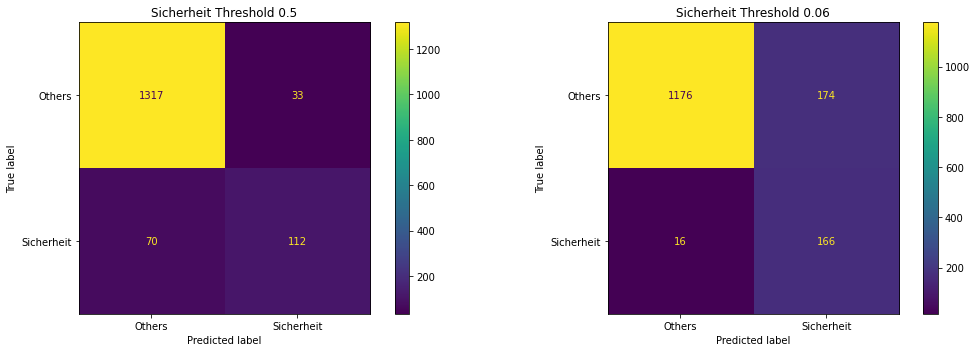

In [96]:
# Thresholds should be carefully tuned, since the optimal threshold increases also FPR
# i.e. Feed of "Sicherheit" will contain a lot of Not-Sicherheit press releases, i.e. Precision is very low
# In below case, with the "optimal threshold" we get 50 more relevant cases, but also 150 irrelevant ones
cm_thres = confusion_matrix(y_true_sicherheit, y_pred_sicherheit)
cm_opt = confusion_matrix(y_true_sicherheit, y_pred_opt)

# Create ConfusionMatrix for each class
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ConfusionMatrixDisplay(cm_thres, display_labels=['Others', label_names[4]]).plot(ax=axs[0])
ConfusionMatrixDisplay(cm_opt, display_labels=['Others', label_names[4]]).plot(ax=axs[1])
axs[0].set_title('Sicherheit Threshold 0.5')
axs[1].set_title('Sicherheit Threshold 0.06')

fig.tight_layout()
plt.show()

In [97]:
# Save model
trainer.save_model(root_dir+'/'+model_name)

Saving model checkpoint to drive/MyDrive/medienmitteilungen/multi_label_medium
Configuration saved in drive/MyDrive/medienmitteilungen/multi_label_medium/config.json
Model weights saved in drive/MyDrive/medienmitteilungen/multi_label_medium/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/medienmitteilungen/multi_label_medium/tokenizer_config.json
Special tokens file saved in drive/MyDrive/medienmitteilungen/multi_label_medium/special_tokens_map.json


### 6. Multi-label classifier with all topics

In [98]:
label_names = list(entries_flat_df['topic_name'].value_counts().index.values)
cols = ['text'] + label_names
cols

['text',
 'Bundesrat',
 'Wirtschaft',
 'Schweiz und Ausland',
 'Gesundheit',
 'Sicherheit',
 'Umwelt und Natur',
 'Statistik',
 'Bildung und Forschung',
 'Verkehr',
 'Soziales',
 'Konsum',
 'Armee',
 'Energie',
 'Technologie',
 'Behörden',
 'Recht',
 'Arbeit',
 'Landwirtschaft',
 'Migration',
 'Steuern',
 'Europa',
 'Bund und Kantone',
 'Finanzplatz',
 'Bundespräsident/-in',
 'Kultur',
 'Öffentliche Finanzen',
 'Informatik und E-Government',
 'Zoll',
 'Kriminalität',
 'Raumplanung',
 'Medien',
 'Ausserordentliche Lagen',
 'Telekommunikation',
 'Politische Rechte',
 'Sport',
 'Bundespersonal',
 'Reisen und Tourismus',
 'Öffentliche Beschaffungen',
 'Gerichte',
 'Bibliotheken und Archive',
 'Parlament',
 'Amtliche Veröffentlichungen',
 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen',
 'Frankenstärke']

In [99]:
label2id = {k:v for v, k in enumerate(label_names)}
label2id

{'Bundesrat': 0,
 'Wirtschaft': 1,
 'Schweiz und Ausland': 2,
 'Gesundheit': 3,
 'Sicherheit': 4,
 'Umwelt und Natur': 5,
 'Statistik': 6,
 'Bildung und Forschung': 7,
 'Verkehr': 8,
 'Soziales': 9,
 'Konsum': 10,
 'Armee': 11,
 'Energie': 12,
 'Technologie': 13,
 'Behörden': 14,
 'Recht': 15,
 'Arbeit': 16,
 'Landwirtschaft': 17,
 'Migration': 18,
 'Steuern': 19,
 'Europa': 20,
 'Bund und Kantone': 21,
 'Finanzplatz': 22,
 'Bundespräsident/-in': 23,
 'Kultur': 24,
 'Öffentliche Finanzen': 25,
 'Informatik und E-Government': 26,
 'Zoll': 27,
 'Kriminalität': 28,
 'Raumplanung': 29,
 'Medien': 30,
 'Ausserordentliche Lagen': 31,
 'Telekommunikation': 32,
 'Politische Rechte': 33,
 'Sport': 34,
 'Bundespersonal': 35,
 'Reisen und Tourismus': 36,
 'Öffentliche Beschaffungen': 37,
 'Gerichte': 38,
 'Bibliotheken und Archive': 39,
 'Parlament': 40,
 'Amtliche Veröffentlichungen': 41,
 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen': 42,
 'Frankenstärke': 43}

In [100]:
id2label = {v:k for v, k in enumerate(label_names)}
id2label

{0: 'Bundesrat',
 1: 'Wirtschaft',
 2: 'Schweiz und Ausland',
 3: 'Gesundheit',
 4: 'Sicherheit',
 5: 'Umwelt und Natur',
 6: 'Statistik',
 7: 'Bildung und Forschung',
 8: 'Verkehr',
 9: 'Soziales',
 10: 'Konsum',
 11: 'Armee',
 12: 'Energie',
 13: 'Technologie',
 14: 'Behörden',
 15: 'Recht',
 16: 'Arbeit',
 17: 'Landwirtschaft',
 18: 'Migration',
 19: 'Steuern',
 20: 'Europa',
 21: 'Bund und Kantone',
 22: 'Finanzplatz',
 23: 'Bundespräsident/-in',
 24: 'Kultur',
 25: 'Öffentliche Finanzen',
 26: 'Informatik und E-Government',
 27: 'Zoll',
 28: 'Kriminalität',
 29: 'Raumplanung',
 30: 'Medien',
 31: 'Ausserordentliche Lagen',
 32: 'Telekommunikation',
 33: 'Politische Rechte',
 34: 'Sport',
 35: 'Bundespersonal',
 36: 'Reisen und Tourismus',
 37: 'Öffentliche Beschaffungen',
 38: 'Gerichte',
 39: 'Bibliotheken und Archive',
 40: 'Parlament',
 41: 'Amtliche Veröffentlichungen',
 42: 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen',
 43: 'Frankenstärke'}

In [101]:
num_labels = len(label_names)
num_labels

44

In [102]:
subset_multi_df = multilabel_count_df[multilabel_count_df[label_names]==1].reset_index().fillna(0.0)[cols]
subset_multi_df = subset_multi_df[subset_multi_df[label_names].sum(axis=1)>0] # Only message where at least one of the required labels is set
subset_multi_df.head()

topic_name,text,Bundesrat,Wirtschaft,Schweiz und Ausland,Gesundheit,Sicherheit,Umwelt und Natur,Statistik,Bildung und Forschung,Verkehr,...,Sport,Bundespersonal,Reisen und Tourismus,Öffentliche Beschaffungen,Gerichte,Bibliotheken und Archive,Parlament,Amtliche Veröffentlichungen,Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen,Frankenstärke
0,"""'Initiative de Paris pour la paix au Proche-O...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""110 years of Swiss-Egyptian business relation...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""70 Jahre UNO: auf dem Weg zu Frieden, Sicherh...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"""A-t-on progressé dans le respect des droits d...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"""Aktuelle europapolitische Themen"" Ansprache v...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Following text appears in two records and point to two different URL, but text is identical
entries_flat_df[entries_flat_df['text']=='Meinungsverfälschende Fernsehbilder Die Unabhängige Beschwerdeinstanz von Radio und Fernsehen UBI hat eine Beschwerde gegen einen Newsbeitrag von Tele Top über eine Demonstration von Tierschützern gutgeheissen. Das Publikum konnte sich dazu aufgrund von irreführenden Bildern und fehlender Hintergrundinformationen keine eigene Meinung bilden. Eine Beschwerde gegen einen Beitrag der "Tagesschau" von Fernsehen SRF über die europapolitische Position der Grünliberalen Partei hat die UBI dagegen abgewiesen.'].link.values

array(['https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.msg-id-74518.html',
       'https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.msg-id-74516.html'],
      dtype=object)

In [104]:
# And its even in the same category (Medien - and only in this category)
multilabel_count_df.loc['Meinungsverfälschende Fernsehbilder Die Unabhängige Beschwerdeinstanz von Radio und Fernsehen UBI hat eine Beschwerde gegen einen Newsbeitrag von Tele Top über eine Demonstration von Tierschützern gutgeheissen. Das Publikum konnte sich dazu aufgrund von irreführenden Bildern und fehlender Hintergrundinformationen keine eigene Meinung bilden. Eine Beschwerde gegen einen Beitrag der "Tagesschau" von Fernsehen SRF über die europapolitische Position der Grünliberalen Partei hat die UBI dagegen abgewiesen.']['Medien']

published
2019-03-29    2
Name: Medien, dtype: int64

In [105]:
# 5442 of approx 17'000 press releases have only one label, see also EDA
subset_multi_df[label_names].sum(axis=1).value_counts().sort_index()

1.0     5443
2.0     5556
3.0     3132
4.0     1691
5.0     1096
6.0      431
7.0      225
8.0       84
9.0       39
10.0      22
11.0      12
12.0       6
13.0       7
14.0       4
15.0       2
16.0       2
17.0       1
18.0       1
32.0       1
dtype: int64

In [106]:
ds = Dataset.from_pandas(subset_multi_df)
ds

Dataset({
    features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', 'Energie', 'Technologie', 'Behörden', 'Recht', 'Arbeit', 'Landwirtschaft', 'Migration', 'Steuern', 'Europa', 'Bund und Kantone', 'Finanzplatz', 'Bundespräsident/-in', 'Kultur', 'Öffentliche Finanzen', 'Informatik und E-Government', 'Zoll', 'Kriminalität', 'Raumplanung', 'Medien', 'Ausserordentliche Lagen', 'Telekommunikation', 'Politische Rechte', 'Sport', 'Bundespersonal', 'Reisen und Tourismus', 'Öffentliche Beschaffungen', 'Gerichte', 'Bibliotheken und Archive', 'Parlament', 'Amtliche Veröffentlichungen', 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen', 'Frankenstärke', '__index_level_0__'],
    num_rows: 17755
})

In [107]:
# create one hot label column
cols = ds.column_names
ds = ds.map(lambda x : {'labels': [x[c] for c in cols if c in label_names]})
ds

Map:   0%|          | 0/17755 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', 'Energie', 'Technologie', 'Behörden', 'Recht', 'Arbeit', 'Landwirtschaft', 'Migration', 'Steuern', 'Europa', 'Bund und Kantone', 'Finanzplatz', 'Bundespräsident/-in', 'Kultur', 'Öffentliche Finanzen', 'Informatik und E-Government', 'Zoll', 'Kriminalität', 'Raumplanung', 'Medien', 'Ausserordentliche Lagen', 'Telekommunikation', 'Politische Rechte', 'Sport', 'Bundespersonal', 'Reisen und Tourismus', 'Öffentliche Beschaffungen', 'Gerichte', 'Bibliotheken und Archive', 'Parlament', 'Amtliche Veröffentlichungen', 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen', 'Frankenstärke', '__index_level_0__', 'labels'],
    num_rows: 17755
})

In [108]:
# Load model and tokenizer as multi-label problem
model_ckpt = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type='multi_label_classification')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf014

In [109]:
ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/17755 [00:00<?, ? examples/s]

In [110]:
# Train/Valid/Test-split
test_trainvalid = ds.train_test_split(test_size=0.1)
train_valid = test_trainvalid['train'].train_test_split(test_size=0.1)

ds_split = DatasetDict({
    'train': train_valid['train'],
    'valid': train_valid['test'],
    'test': test_trainvalid['test']
})

ds_split

DatasetDict({
    train: Dataset({
        features: ['text', 'Bundesrat', 'Wirtschaft', 'Schweiz und Ausland', 'Gesundheit', 'Sicherheit', 'Umwelt und Natur', 'Statistik', 'Bildung und Forschung', 'Verkehr', 'Soziales', 'Konsum', 'Armee', 'Energie', 'Technologie', 'Behörden', 'Recht', 'Arbeit', 'Landwirtschaft', 'Migration', 'Steuern', 'Europa', 'Bund und Kantone', 'Finanzplatz', 'Bundespräsident/-in', 'Kultur', 'Öffentliche Finanzen', 'Informatik und E-Government', 'Zoll', 'Kriminalität', 'Raumplanung', 'Medien', 'Ausserordentliche Lagen', 'Telekommunikation', 'Politische Rechte', 'Sport', 'Bundespersonal', 'Reisen und Tourismus', 'Öffentliche Beschaffungen', 'Gerichte', 'Bibliotheken und Archive', 'Parlament', 'Amtliche Veröffentlichungen', 'Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen', 'Frankenstärke', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14381
    })
    valid: Dataset({
        features: ['text', 'Bundesr

In [111]:
ds_split.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [112]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           problem_type='multi_label_classification').to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Bundesrat",
    "1": "Wirtschaft",
    "2": "Schweiz und Ausland",
    "3": "Gesundheit",
    "4": "Sicherheit",
    "5": "Umwelt und Natur",
    "6": "Statistik",
    "7": "Bildung und Forschung",
    "8": "Verkehr",
    "9": "Soziales",
    "10": "Konsum",
    "11": "Armee",
    "12": "Energie",
    "13": "Technologie",
    "14": "Beh\u00f6rden",
    "15": "Recht",
    "16": "Arbeit",
    "17": "Landwirtschaft",
    "18": "Migration",
    "19": "Steuern",
    "20": "Europa",
    "21": "Bund und Kantone",
    "22": "Finanzplatz

In [113]:
batch_size = 32
model_name = 'multi_label_large'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=len(ds_split['train']) // batch_size)

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_split['train'],
                  eval_dataset=ds_split['valid'],
                  tokenizer=tokenizer)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Bundespersonal, Wirtschaft, Technologie, Politische Rechte, Konsum, Bundesrat, Zoll, Finanzplatz, Europa, Bund und Kantone, Energie, Sport, Frankenstärke, Landwirtschaft, text, Bildung und Forschung, Bibliotheken und Archive, Öffentliche Finanzen, Raumplanung, Öffentliche Beschaffungen, Soziales, Recht, Arbeit, Verkehr, Ausserordentliche Lagen, Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen, Bundespräsident/-in, Kultur, Umwelt und Natur, Schweiz und Ausland, Medien, Armee, Gesundheit, Sicherheit, Kriminalität, Statistik, Amtliche Veröffentlich

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.159300,0.104676,0.334168,0.596745
2,0.087100,0.080358,0.452441,0.725440
3,0.066500,0.073546,0.481227,0.753030
4,0.055200,0.070135,0.494994,0.764556
5,0.048000,0.069350,0.496245,0.767597


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Bundespersonal, Wirtschaft, Technologie, Politische Rechte, Konsum, Bundesrat, Zoll, Finanzplatz, Europa, Bund und Kantone, Energie, Sport, Frankenstärke, Landwirtschaft, text, Bildung und Forschung, Bibliotheken und Archive, Öffentliche Finanzen, Raumplanung, Öffentliche Beschaffungen, Soziales, Recht, Arbeit, Verkehr, Ausserordentliche Lagen, Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen, Bundespräsident/-in, Kultur, Umwelt und Natur, Schweiz und Ausland, Medien, Armee, Gesundheit, Sicherheit, Kriminalität, Statistik, Amtliche Veröffentlichungen, Reisen und Tourismus, Informatik und E-Government, __index_level_0__, Steuern, Behörden, Parlament, Gerichte, Migration, Telekommunikation. If Bundespersonal, Wirtschaft, Technologie, Politische Rechte, Konsum, Bundesrat, Zoll, Finanzplatz, Europa, Bund und Kantone, Energie, Sport, Fran

TrainOutput(global_step=2250, training_loss=0.08316050064563751, metrics={'train_runtime': 984.3874, 'train_samples_per_second': 73.045, 'train_steps_per_second': 2.286, 'total_flos': 1.159061096505444e+16, 'train_loss': 0.08316050064563751, 'epoch': 5.0})

In [114]:
pred_test = trainer.predict(ds_split['test'])
pred_test.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Bundespersonal, Wirtschaft, Technologie, Politische Rechte, Konsum, Bundesrat, Zoll, Finanzplatz, Europa, Bund und Kantone, Energie, Sport, Frankenstärke, Landwirtschaft, text, Bildung und Forschung, Bibliotheken und Archive, Öffentliche Finanzen, Raumplanung, Öffentliche Beschaffungen, Soziales, Recht, Arbeit, Verkehr, Ausserordentliche Lagen, Zuwanderung – Umsetzung der neuen Verfassungsbestimmungen, Bundespräsident/-in, Kultur, Umwelt und Natur, Schweiz und Ausland, Medien, Armee, Gesundheit, Sicherheit, Kriminalität, Statistik, Amtliche Veröffentlichungen, Reisen und Tourismus, Informatik und E-Government, __index_level_0__, Steuern, Behörden, Parlament, Gerichte, Migration, Telekommunikation. If Bundespersonal, Wirtschaft, Technologie, Politische Rechte, Konsum, Bundesrat, Zoll, Finanzplatz, Europa, Bund und Kantone, Energie, Sport, Frankenstä

{'test_loss': 0.06886853277683258,
 'test_accuracy': 0.48986486486486486,
 'test_f1': 0.7658300872052204,
 'test_runtime': 7.4253,
 'test_samples_per_second': 239.183,
 'test_steps_per_second': 7.542}

In [115]:
pred_test.predictions

array([[ 0.42465755, -5.6355605 , -4.8839617 , ..., -4.747333  ,
        -5.432903  , -5.1997266 ],
       [-4.480807  , -3.5753322 , -3.8772488 , ..., -7.40853   ,
        -7.476365  , -7.607724  ],
       [-4.2629657 , -4.6339793 , -3.8847475 , ..., -6.4305854 ,
        -6.6130147 , -7.1817436 ],
       ...,
       [-2.9006894 , -4.930785  , -4.8405375 , ..., -6.5525885 ,
        -6.7925873 , -6.6913004 ],
       [-3.1657019 , -2.676752  , -2.0706708 , ..., -5.655117  ,
        -5.7439346 , -5.616022  ],
       [ 4.229987  , -1.6188552 , -3.6823733 , ..., -6.1170845 ,
        -6.4027576 , -6.2580624 ]], dtype=float32)

In [116]:
# Transform prediction to probabilities and then use threshold
# see: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
y_pred = pred_test.predictions
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(y_pred)) # see https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
y_pred_thresh = np.zeros(probs.shape)
y_pred_thresh[np.where(probs >= 0.5)] = 1
y_true = pred_test.label_ids.astype(int)

In [117]:
print(classification_report(y_true, y_pred_thresh, target_names=label_names))

                                                           precision    recall  f1-score   support

                                                Bundesrat       0.88      0.92      0.90       629
                                               Wirtschaft       0.87      0.83      0.85       471
                                      Schweiz und Ausland       0.88      0.81      0.84       426
                                               Gesundheit       0.88      0.81      0.84       183
                                               Sicherheit       0.81      0.67      0.73       188
                                         Umwelt und Natur       0.88      0.80      0.84       171
                                                Statistik       0.82      0.88      0.85       120
                                    Bildung und Forschung       0.84      0.76      0.80       136
                                                  Verkehr       0.89      0.81      0.85       114
         

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
cm = multilabel_confusion_matrix(y_true, y_pred_thresh)
cm.shape

(44, 2, 2)

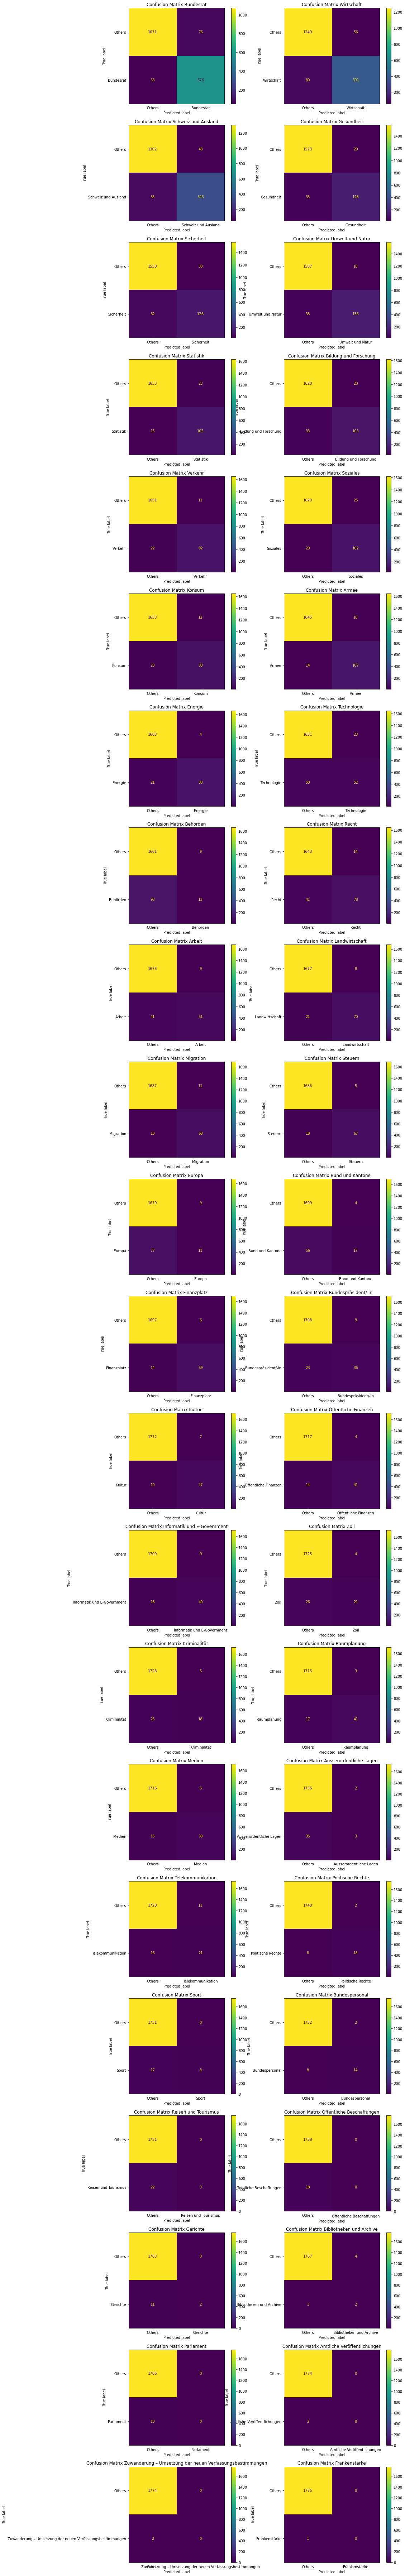

In [119]:
# Create ConfusionMatrix for each class
fig, axs = plt.subplots(nrows=22, ncols=2, figsize=(15,100))

for idx, (label, ax) in enumerate(zip(label_names, axs.ravel())):
  ConfusionMatrixDisplay(cm[idx], display_labels=['Others', label_names[idx]]).plot(ax=ax)
  ax.set_title(f'Confusion Matrix {label_names[idx]}')

fig.tight_layout()
plt.show()

In [121]:
# Save model
trainer.save_model(root_dir+'/'+model_name)

Saving model checkpoint to drive/MyDrive/medienmitteilungen/multi_label_large
Configuration saved in drive/MyDrive/medienmitteilungen/multi_label_large/config.json
Model weights saved in drive/MyDrive/medienmitteilungen/multi_label_large/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/medienmitteilungen/multi_label_large/tokenizer_config.json
Special tokens file saved in drive/MyDrive/medienmitteilungen/multi_label_large/special_tokens_map.json


### 7. Prediction on new data

In [122]:
# Load model and build pipeline object
clf_medium = pipeline('text-classification', root_dir+'/multi_label_medium', return_all_scores=True)
clf_large = pipeline('text-classification', root_dir+'/multi_label_large', return_all_scores=True)

loading configuration file drive/MyDrive/medienmitteilungen/multi_label_medium/config.json
Model config BertConfig {
  "_name_or_path": "drive/MyDrive/medienmitteilungen/multi_label_medium",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Bundesrat",
    "1": "Wirtschaft",
    "2": "Schweiz und Ausland",
    "3": "Gesundheit",
    "4": "Sicherheit",
    "5": "Umwelt und Natur",
    "6": "Statistik",
    "7": "Bildung und Forschung",
    "8": "Verkehr",
    "9": "Soziales",
    "10": "Konsum",
    "11": "Armee"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Armee": 11,
    "Bildung und Forschung": 7,
    "Bundesrat": 0,
    "Gesundheit": 3,
    "Konsum": 10,
    "Schweiz und Ausland": 2,
    "Sicherheit": 4,
    "Soziales": 9,
    "Statistik": 6,
    "Umwelt und Natur"

In [123]:
# Press release of 8.3.2023
# Link: https://www.admin.ch/gov/de/start/dokumentation/medienmitteilungen.msg-id-93451.html
text = 'Armee überführt Verwaltungsinformatik ins Bundesamt für Informatik und Telekommunikation \
        Die Verwaltungsinformatik der Armee wird zukünftig durch das Bundesamt für Informatik und \
        Telekommunikation im Eidgenössischen Finanzdepartement (EFD) sichergestellt. Damit kann sich \
        die Gruppe Verteidigung auf die einsatzkritischen IKT-Leistungen, wie zum Beispiel die \
        Rechenzentren VBS, konzentrieren. Mit dieser Entflechtung will der Bundesrat die Sicherheit \
        erhöhen und Synergien nutzen. An seiner Sitzung vom 3. März 2023 hat er vom geplanten Vorgehen \
        zur Entflechtung Kenntnis genommen und das VBS beauftragt, die nötigen Arbeiten in Zusammenarbeit \
        mit dem EFD in einem Programm umzusetzen. Die Entflechtung geht auf die IKT-Strategie des Bundes \
        2020-2023 zurück, die der Bundesrat im April 2020 festgelegt hatte.'

pred_medium = clf_medium(text)
pred_large = clf_large(text)

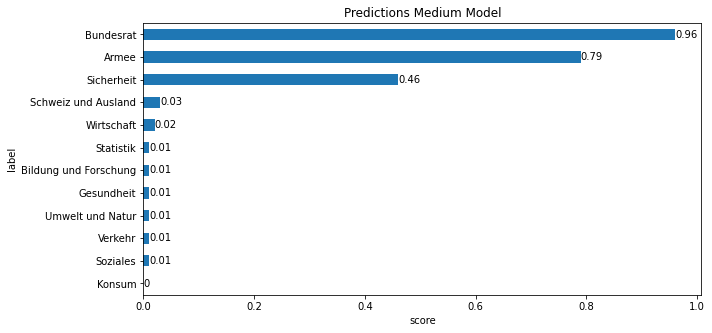

In [124]:
scores_df = pd.DataFrame(pred_medium[0]).sort_values(by='score', ascending=False)
scores_df['score'] = scores_df['score'].apply(lambda x: round(x, 2))
ax = scores_df.set_index('label').sort_values(by='score').plot.barh(legend=False, figsize=(10,5))
ax.bar_label(ax.containers[0])
plt.xlabel('score')
plt.title('Predictions Medium Model')
plt.show()

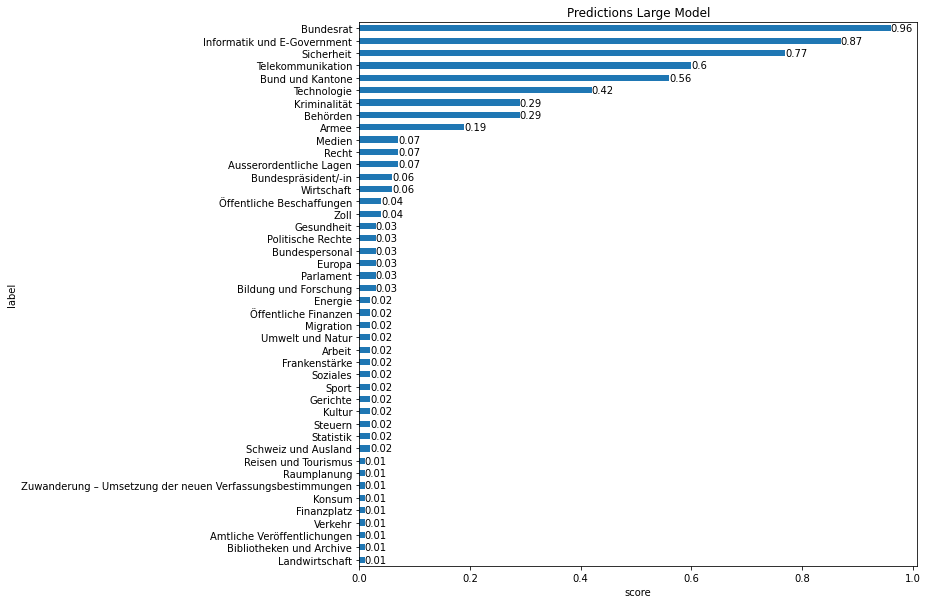

In [125]:
scores_df = pd.DataFrame(pred_large[0]).sort_values(by='score', ascending=False)
scores_df['score'] = scores_df['score'].apply(lambda x: round(x, 2))
ax = scores_df.set_index('label').sort_values(by='score').plot.barh(legend=False, figsize=(10,10))
ax.bar_label(ax.containers[0])
plt.xlabel('score')
plt.title('Predictions Large Model')
plt.show()

### 8. Summary and future work

<b>Summary</b>
- EDA showed that same press releases (defined as a combination of title+text+published date) are assigned to multiple topics.
- A large amount of press releases are always also assigned to topic "Bundesrat". This topic apparently serves as some kind of default topic.
- There are topics with no recent press releases (i.e. one-off-topics created only for special situations such as "Frankenstärke")
- Overall performance of multi-label classification with German BERT model can be considered "good", for the top 12 topics model with more than 1200 press releases (F1 Score: 87 %)
- Performance including all 44 classes is rather "weak" overall (F1 Score: 77 %)
- Ground truth seems subjective and based on personal opinions (maybe instructions exist on how to assign press releases, but are not always followed). We should therefore carefully look at examples which are "wrongly" classified by our model since it might in fact highlight some wrong topic assignments.
- F1 scores of two largest topics "Wirtschaft" and "Schweiz und Ausland" decrease when including more classes
- Topics "Armee" and "Sicherheit" have similar amount of press releases (approx 1200 vs. 1900) and have one of the largest overlaps of press releases (60 % of "Armee" press releases are also classified as "Sicherheit" and 40% of "Sicherheit" press releases are also classified as "Armee"). But interestingly they have very different performance F1 scores ("Sicherheit" even has the worst performance of the top topics)
- Classifiers could be used to propose topic classification on new data


<b>Future Work</b>
- Systematically find mislabeled ground truth data
- Use individual thresholds for each class, since each class is treated as a binary classification problem in multi-label classification
- Tuning of thresholds should take higher costs of false positives into consideration (i.e. costs of manually filtering out irrelevant information are higher than the costs of missing a handful of relevant information), topics serve as recommendations and recommending irrelevant information makes the recommendation system useless
- Refine topic and data subset for classifier:
  - Ignore "Bundesrat" default topic
  - Ignore topics with only few total press releases
  - Ignore topics with no recent press releases (i.e. "Frankenstärke" and "Zuwanderung")
  - Handling imbalanced classes
- Stratify in train/valid/test split in multi-label setting
- Detailed investigation bad performance of topic "Sicherheit"
- Proposing topic classification for new data not based on classifiers but with different techniques (e.g. nearest neighbor based on BERT embeddings)

### References
- Tunstall, L., Von Werra, L. & Wolf, T. (2022). Natural Language Processing with Transformers. O'Really Media   

- Multilabel text classification with Bert:   
https://szuyuchu.medium.com/multi-label-text-classification-with-bert-52fa78eddb9

- Multilabel classification with Huggingface:   
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

- Finetune model for multilabel:   
https://discuss.huggingface.co/t/fine-tune-for-multiclass-or-multilabel-multiclass/4035/20?page=2

- Multilabel classification with Trainer API:   
https://discuss.huggingface.co/t/multilabel-text-classification-trainer-api/11508/2

- Encode labels for multilabel problem:   
https://colab.research.google.com/drive/1aue7x525rKy6yYLqqt-5Ll96qjQvpqS7
https://discuss.huggingface.co/t/dataset-label-format-for-multi-label-text-classification/14998/4

- Train/Valid/Test split HuggingFace datasets:   
https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2

- Predicting on new text:   
https://discuss.huggingface.co/t/predicting-on-new-text-with-fine-tuned-multi-label-model/13046/2

- BCE Loss with logits:   
https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/20   

- Using pipelines for inference:
https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.TextClassificationPipeline   

- id2label and label2id configuration:   
https://towardsdatascience.com/transformer-models-for-custom-text-classification-through-fine-tuning-3b065cc08da1

- Cutoff Thresholds Youden index:   
https://gist.github.com/twolodzko/4fae2980a1f15f8682d243808e5859bb   
https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python   

- Evaluating multilabel classification:  
https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea   

- Precision vs. Recall in Recommender Systems (e.g. Youtube):    
https://levity.ai/blog/precision-vs-recall   

- Interpreting ROC and AUC:   
https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077